![](1.jpg)

## Дипломный проект

## Учебный кейс «Модель прогнозирования стоимости жилья для агентства недвижимости»

**Задача**: агентство недвижимости столкнулось с проблемой — риелторы тратят слишком много времени на сортировку объявлений и поиск выгодных предложений. Поэтому скорость их реакции и качество анализа не дотягивают до уровня конкурентов. Это сказывается на финансовых показателях агентства.

**Цель** — разработать модель машинного обучения, которая поможет обрабатывать объявления и увеличит число сделок и прибыль агентства.

**Основные этапы проекта:**

1. Произвести предобработку и разведывательный анализ набора реальных данных (обработать пропуски, дубликаты и выбросы, устранить ошибки ввода, расшифровать сокращения, отыскать закономерности, сгенерировать новые признаки с использованием внешних источников).
2. Выделить наиболее значимые факторы, влияющие на стоимость недвижимости.
3. Построить несколько моделей для прогнозирования стоимости недвижимости и отобрать лучшую по целевой метрике.

### Описание данных:

- 'status' — статус продажи;
- 'private pool' и 'PrivatePool' — наличие собственного бассейна;
- 'propertyType' — тип объекта недвижимости;
- 'street' — адрес объекта;
- 'baths' — количество ванных комнат;
- 'homeFacts' — сведения о строительстве объекта (содержит несколько
типов сведений, влияющих на оценку объекта);
- 'fireplace' — наличие камина;
- 'city' — город;
- 'schools' — сведения о школах в районе;
- 'sqft' — площадь в футах;
- 'zipcode' — почтовый индекс;
- 'beds' — количество спален;
- 'state' — штат;
- 'stories' — количество этажей;
- 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система
мультилистинга);
- target' — цена объекта недвижимости (целевой признак, который
необходимо спрогнозировать).

In [1]:
# Загрузка необходимых библиотек
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import re
import requests
from bs4 import BeautifulSoup
import json

import category_encoders as ce
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, chi2
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from catboost import Pool, CatBoostRegressor
import optuna
import pickle
import scipy.stats as stats

import geopy.geocoders
from geopy.geocoders import Nominatim

import warnings
warnings.filterwarnings('ignore')

## Исследование данных

In [2]:
# Загрузка данных
df = pd.read_csv('data.csv')
display(df.head(3))

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"


In [3]:
# Исследуем признаки в данных
display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

None

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
count,337267,4181,342452,377183,270847,377185,103115,377151,377185,336608,377185,285903,377185,226470,24942,40311,310305,374704
unique,159,1,1280,337076,229,321009,1653,2026,297365,25405,4549,1184,39,348,24907,2,232944,43939
top,for sale,Yes,single-family home,Address Not Disclosed,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",yes,Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32137,3 Beds,FL,1.0,No MLS#,yes,NO MLS,"$225,000"
freq,156104,4181,92206,672,52466,7174,50356,24442,4204,11854,2141,53459,115449,67454,3,28793,24,1462


Посмотрим на признаки с высоким процентом уникальных значений, они могут быть рассмотрены как неинформативные:

- "street" содержит 89% уникальных значений и представляет адрес объекта недвижимости. Множество одинаковых названий включает в себя дубликаты, а также записи с отсутствующими адресами, которые возможно будут удалены при обработке данных.

- "homeFacts" имеет 85% уникальных значений и содержит информацию о различных характеристиках объектов недвижимости, таких как год постройки, наличие парковки и другие. Думаю из этого признака можно извлечь полезную информацию и после удалить.

- "schools" содержит 79% уникальных значений и представляет информацию о школах, находящихся рядом с объектами недвижимости. 

Несмотря на большое количество уникальных значений в данных признаках, они будут проанализированы в разделе EDA с целью выделения нужной информации и проектирования новых признаков.

## Дубликаты в данных

In [4]:
dupl_columns = list(df.columns)

mask = df.duplicated(subset=dupl_columns)
duplicates = df[mask]
print(f'Число найденных дубликатов: {duplicates.shape[0]}')

Число найденных дубликатов: 50


В данных есть небольшое количество полных дубликатов (50 записей), которые могут быть удалены.

## Пропуски в данных

In [5]:
cols_null_percent = df.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

private pool    98.891525
mls-id          93.387330
PrivatePool     89.312672
fireplace       72.661956
stories         39.957846
baths           28.192532
beds            24.200856
MlsId           17.731352
sqft            10.757851
status          10.583136
propertyType     9.208479
target           0.657767
city             0.009014
street           0.000530
dtype: float64

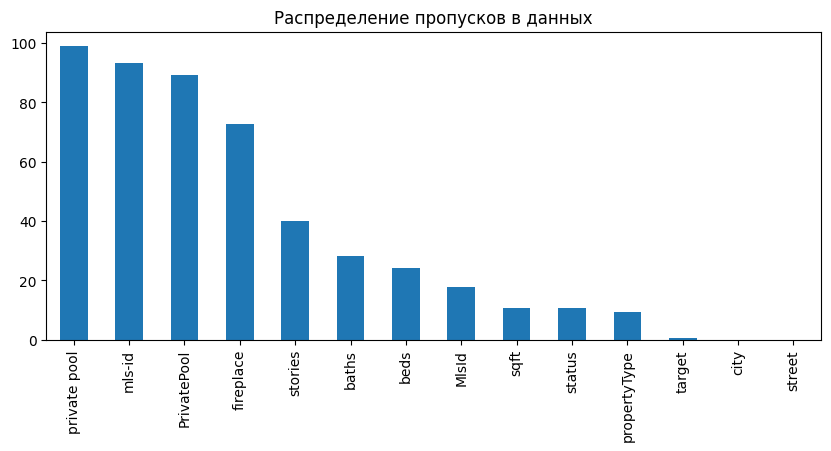

In [6]:
cols_with_null.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков в данных'
);

В данных присутствует значительное количество пропущенных значений, которые требуется рассмотреть и обработать:

- Признаки "private pool" и "PrivatePool," которые указывают на наличие частного бассейна, содержат 99% и 89% пропущенных значений соответственно. Пропуски скорее всего означают отсутствие бассейна. Мы попробуем объединить данные признаки в один и исследовать.

- Признак "msl-id" содержит 93% пропусков, а его аналог "MlsId" - всего 18%. Возможно, после объединения этих признаков количество пропусков станет допустимым. Но стоит отметить, что данный признак абсолютно неинформативен, так как дублирует информацию из других признаков (город объекта, штат, почтовый индекс).

- Признак "fireplace" - 73% пустых значений, что довольно много. Будем считать, что пропуски в признаке наличия камина также указывают на его отсутствие. 

- Целевой признак "target" содержит менее 1% пропущенных значений, эти записи могут быть удалены, так как столь небольшой процент не повлияет на построение модели.

## Предобработка и очистка данных

In [7]:
# Вывод размерности датафрейма до предобработки
print('Размерность датафрейма до предобработки:', df.shape)

# Сохранение исходных размеров датафрейма
original_rows, original_cols = df.shape

# Удаление ненужных признаков
columns_to_drop = ['mls-id', 'MlsId']
df.drop(columns_to_drop, axis=1, inplace=True)

# Удаление строк с пропусками в целевом признаке 'target' 
df.dropna(subset=['target'], inplace=True)

# Удаление полных дубликатов
df.drop_duplicates(inplace=True)

# Вывод размерности датафрейма после предобработки
print('Размерность датафрейма после предобработки:', df.shape)

# Вывод информации о количестве удаленных строк и столбцов
removed_rows = original_rows - df.shape[0]
removed_cols = original_cols - df.shape[1]

Размерность датафрейма до предобработки: (377185, 18)


Размерность датафрейма после предобработки: (374564, 16)


## Обработка признака "status"

In [8]:
# посмотрим, какие значения может принимать данный признак
df.status.unique()

array(['Active', 'for sale', nan, 'New construction', 'New', 'For sale',
       'Pending', 'P', 'Active/Contingent', ' / auction',
       'Under Contract', 'Pre-foreclosure / auction',
       'Under Contract   Showing', 'Pre-foreclosure',
       'Under Contract Backups', 'Active Under Contract', 'foreclosure',
       'Foreclosed', 'Option Pending', 'Under Contract Show', 'for rent',
       'Auction', 'A Active', 'Contingent', 'Pending   Continue To Show',
       'Price Change', 'Back on Market', 'Active Option', 'Foreclosure',
       'Coming soon: Nov 21.', 'Contingent Finance And Inspection',
       'Coming soon: Dec 4.', 'P Pending Sale', 'Coming soon: Nov 23.',
       'Active With Contingencies', 'Pending Ab', 'Pf', 'Contingent Show',
       'Contract P', 'Contingent Take Backup', 'Apartment for rent',
       'Backup Contract', 'Option Contract', 'Pending Continue To Show',
       'pending', 'Pending Inspection', 'Active Option Contract', 'C',
       'Auction - Active', 'Contingent 

Видно, что данный признак очень низкого качества. В нём можно заметить множество различных обазначений для практически одного статуса. 

In [9]:
# посмотрим на количество уникальных значений
df.status.nunique()

156

In [10]:
# Посмотрим на наиболее часто встречающиеся значения
df.status.value_counts().nlargest(10)

for sale                     156048
Active                       105124
For sale                      43464
foreclosure                    5677
New construction               5458
Pending                        4696
Pre-foreclosure                2000
P                              1488
Pre-foreclosure / auction      1281
Under Contract Show            1183
Name: status, dtype: int64

Признак может принимать одинаковые значения, написанные разным реестром - 'for sale', 'For sale', 'For Sale', объединим их в один. Все значения данного признака,  для удобства, можно привести в нижний регистр.

In [11]:
# приводим всё к нижнему регистру
df.status = df.status.str.lower()

Встречаются значения, отличающиеся запятой, лишней буквой, наличием лишнего пробела и прочее, что скорее всего говорит об ошибке заполняющего базу данных оператора.

In [12]:
# выполним преобразования для подобных случаев
status_replacements = {
    'a active': 'active',
    ' ': '',
    ',': '',
    'pendingw/cont.': 'pendingwithcontingencies',
    'active-contingent': 'activecontingent',
    'active/contingent': 'activecontingent',
    'activecontingency': 'activecontingent',
    'activewithcontingencies': 'activecontingent',
    '/auction': 'auction',
    'active-auction': 'auction-active',
    'uundercontract': 'undercontract',
    'undercontractshowing': 'undercontractshow',
    'undercontract-show': 'undercontractshow',
    '^comingsoon.*': 'comingsoon',
    '^sold.*': 'recentlysold'
}

# Применяем замену для каждого значения в словаре
for old, new in status_replacements.items():
    df['status'] = df['status'].str.replace(old, new, regex=True)

In [13]:
# Посмотрим теперь на наиболее часто встречающиеся значения
df.status.value_counts().nlargest(25)

forsale                           199514
active                            105567
foreclosure                         6020
newconstruction                     5458
pending                             4801
pre-foreclosure                     2000
undercontractshow                   1984
p                                   1488
auction                             1292
pre-foreclosureauction              1281
activeundercontract                  718
undercontract                        702
new                                  690
contingent                           581
pricechange                          563
forrent                              398
foreclosed                           294
undercontractbackups                 252
contingentfinanceandinspection       245
pendingcontinuetoshow                198
contingentshow                       114
backonmarket                         112
comingsoon                           110
optionpending                        110
pendingtakingbac

Необходимо ограничить количество значений данного признака из-за большого числа уникальных значений, объединив статусы, имеющие схожий смысл, а также объединив небольшие группы в категорию "Other".

Статус "Active" (Активно) означает, что недвижимость активно продается на рынке. Это значит, что данное объявление по-прежнему актуально, и недвижимость доступна для продажи.

"For Sale" (На продажу) - это скорее описание состояния недвижимости, чем ее статус. Это означает, что недвижимость предназначена для продажи. Объект недвижимости может быть объявлен как "For Sale", чтобы показать потенциальным покупателям, что он доступен для покупки. Объявление "For Sale" может быть активным (в статусе "Active") или неактивным, если недвижимость снята с рынка, и объявление больше не актуально.

Итак, разница между "Active" и "For Sale" есть и заключается в следующем: "Active" указывает на текущий статус объявления о продаже на рынке и активность продажи, в то время как "For Sale" просто описывает факт того, что недвижимость доступна для продажи, независимо от ее текущего статуса на рынке. Это означает, что мы не можем их объединить.

Foreclosure real estate – это процесс продажи, и, соответственно, покупки через аукцион, поэтому объединим его со статусом "Auction".

Pending (Ожидание): Этот статус указывает на то, что продавец и покупатель заключили договор о продаже недвижимости, и сделка находится в процессе завершения. 

Contingency (Обусловленность): Статус "Contingency" указывает на то, что сделка также находится в процессе завершения, но в ней есть определенные условия (или обусловленности), которые должны быть выполнены, прежде чем сделка будет завершена. Сюда же отнесём статус "Under Contract" (под контрактом) -  продавец и покупатель достигли соглашения и подписали контракт, но сделка пока не завершена, так как ещё не выполнены все условия контракта.

New Construction (Новое строительство): Статус "New Construction" означает, что объект недвижимости является новым строительством или недавно построенным жилым помещением.

Coming Soon (Скоро в продаже): "Coming Soon" означает, что недвижимость будет доступна для продажи в ближайшем будущем, но на момент объявления ее еще нельзя купить или арендовать. Думаю логически можно объединить с "For Sale".

Записи с жильем под аренду "Rent" мы удалим, потому что целевой признак для такого жилья указан за месяц и не поможет нам в предсказании.

In [14]:
# categories_status - это словарь, который сопоставляет более общие категории статусов недвижимости
# с их соответствующими вариантами статусов.
categories_status = {
    "For Sale": ["forsale", "commingsoon", "backonmarket", "pricechange", "recentlysold"], 
    "Active": ["active", "activeundercontract", "activecontingent"], 
    "Pending": ["p", "pending", "pendingcontinuetoshow", "optionpending ", "pendingtakingbackups",
        "pendingwithcontingencies"],  
    "Contingent": ["contingent", "undercontractshow", "undercontract", "undercontractbackups",
        "contingentfinanceandinspection ", "contingentshow"],
    "Foreclosure": [
        "pre-foreclosure", "foreclosure", "pre-foreclosureauction", "foreclosed", "auction",
        "auction-active"],
    "New": ["new", "newconstruction"],
}

In [15]:
# Функция categorize_status принимает значение статуса (status_value) и
# ищет его в словаре categories_status, чтобы вернуть соответствующую категорию.
def categorize_status(status_value):
    for category, values in categories_status.items():
        if status_value in values:
            return category
    return "Other"
# category_mapping - это словарь, который связывает каждое уникальное значение
# в столбце 'status' с его соответствующей категорией.
category_mapping = {value: category for category, values in categories_status.items() for value in values}

df['status'] = df['status'].map(category_mapping).fillna("Other")

In [16]:
# Фильтруем и оставляем только строки, где статус не содержит "rent" (регистронезависимо)
df = df[~df['status'].str.contains('rent', case=False)]

In [17]:
# выполним проверку
missing_values_count = df['status'].isna().sum()
unique_values = df['status'].unique()
sorted_unique_values = sorted(unique_values)

print(f"Статусы в данных:")
print(f"Количество пропущенных значений: {missing_values_count}")
print(f"Уникальные статусы: {sorted_unique_values}")

Статусы в данных:
Количество пропущенных значений: 0
Уникальные статусы: ['Active', 'Contingent', 'For Sale', 'Foreclosure', 'New', 'Other', 'Pending']


##  Обработка признака "private pool"

В датафрейме присутсвуют два дублирующих друг друга признака с одинаковым названием, но разным написанием: private pool и PrivatePool, объединим их.

In [18]:
# Объединяем две колонки и делаем признак бинарным
df['private_pool'] = df['PrivatePool'].combine_first(df['private pool'])  # Объединяем значения из обеих колонок, предпочитая PrivatePool
df.drop(['private pool', 'PrivatePool'], axis=1, inplace=True)

# Преобразуем значения в бинарный формат
df['private_pool'] = df['private_pool'].str.lower().replace({'yes': 1, 'no': 0}).fillna(0).astype(int)

## Обработка признака "propertyType"

In [19]:
# посмотрим количество уникальных значений
df.propertyType.nunique()

1279

In [20]:
# посмотрим какие вообще бывают значения
df.propertyType.sort_values(ascending=False).unique().tolist()

['unknown',
 'townhouse',
 'single-family home',
 'multi-family',
 'mobile/manufactured',
 'lot/land',
 'coop',
 'condo',
 'coastal',
 'apartment',
 'YES',
 'Warehouse',
 'Walk-Out Ranch',
 'Villa',
 'Victorian/Federal',
 'Victorian, Craftsman',
 'Victorian, Bilevel',
 'Victorian',
 'Urban Contemporary',
 'Two Story, Tri-Level',
 'Two Story, Split-Level',
 'Two Story, Spanish/Mediterranean',
 'Two Story, Low Rise',
 'Two Story, Duplex',
 'Two Story',
 'Tuscan',
 'Tudor/Provincial',
 'Tudor',
 'Triplex',
 'Trinity',
 'Tri-Level, Traditional',
 'Tri-Level, Northwestern Contemporary',
 'Tri-Level, Modern',
 'Tri-Level, Craftsman',
 'Tri-Level, Contemporary',
 'Tri-Level',
 'Transitional, Williamsburg',
 'Transitional, Colonial',
 'Transitional',
 'Traditional, Zero-Lot Line',
 'Traditional, Williamsburg',
 'Traditional, Victorian',
 'Traditional, Transitional, Williamsburg',
 'Traditional, Transitional, Cottage',
 'Traditional, Transitional',
 'Traditional, Texas Hill Country',
 'Traditio

In [21]:
# приравняем названия к одному регистру
df.propertyType = df.propertyType.str.lower()

Поскольку уникальных значений признака чересчур много, целесообразно объединить их в схожие группы по названию, путем отсечения всего, что находится после ключевых слов. 

In [22]:
# property_type_replacements - это словарь, который содержит замены 
# для различных вариантов значений типа недвижимости (property type).
property_type_replacements = {
    'single-family home': 'single family',
    'single family home': 'single family',
    '^victorian.*': 'victorian',
    '^two story.*': 'two story',
    '^tri-level.*': 'tri-level',
    '^transitional.*': 'transitional',
    '^traditional.*': 'traditional',
    '^townhome.*': 'townhouse',
    '^townhouse.*': 'townhouse',
    '^texas hill country.*': 'texas hill country',
    '^straight thru.*': 'straight thru',
    '^split.*': 'split',
    '^spanish.*': 'spanish',
    '^single wide.*': 'single wide',
    '^single-wide.*': 'single wide',
    '^single detached.*': 'single detached',
    '^side-by-side.*': 'side-by-side',
    '^rustic.*': 'rustic',
    '^resort property.*': 'resort property',
    '^ranch.*': 'ranch',
    '^raised ranch.*': 'raised ranch',
    '^penthouse.*': 'penthouse',
    '^patio.*': 'patio',
    '^other.*': 'other',
    '^one story.*': 'one story',
    '^old world.*': 'old world',
    '^multiplex.*': 'multiplex',
    '^multi-level.*': 'multi-level',
    '^multi-family.*': 'multi family',
    '^multi-family home.*': 'multi family',
    '^multi generational.*': 'multi generational',
    '^modernist.*': 'modern',
    '^modern.*': 'modern',
    '^mobile.*': 'mobile home',
    '^mid-rise.*': 'mid-rise',
    '^mid rise.*': 'mid-rise',
    '^mid-century.*': 'mid-century',
    '^mid century.*': 'mid-century',
    '^mfd/mobile.*': 'mfd/mobile',
    '^manuf/mobile.*': 'mfd/mobile',
    '^mediterranean.*': 'mediterranean',
    '^manufactured.*': 'manufactured',
    '^low-rise.*': 'low rise',
    '^low rise.*': 'low rise',
    '^log.*': 'log',
    '^loft.*': 'loft',
    '^less than 4 floors.*': 'less than 4 floors',
    '^lake house.*': 'lake house',
    '^key west.*': 'key west',
    '^english.*': 'english',
    '^end unit.*': 'end unit',
    '^elevated.*': 'elevated',
    '^dutch.*': 'dutch',
    '^duplex.*': 'duplex',
    '^detached.*': 'detached',
    '^designated historical home.*': 'designated historical home',
    '^custom.*': 'custom',
    '^craftsman.*': 'craftsman',
    '^courtyard.*': 'courtyard',
    '^cottage.*': 'cottage',
    '^cooperative.*': 'coop',
    '^contemporary.*': 'contemporary',
    '^condominium.*': 'condominium',
    '^condo/unit.*': 'condo/unit',
    '^condo/townhome.*': 'condo/townhome',
    '^condo, other.*': 'condo',
    '^colonial.*': 'colonial',
    '^coastal.*': 'coastal',
    '^coach/carriage.*': 'coach/carriage',
    '^co-op.*': 'coop',
    '^cluster home.*': 'cluster home',
    '^charleston.*': 'charleston',
    '^chalet.*': 'chalet',
    '^carriage.*': 'carriage',
    '^cape.*': 'cape',
    '^camp.*': 'camp',
    '^cabin.*': 'cabin',
    '^bungalow.*': 'bungalow',
    '^bilevel.*': 'bilevel',
    '^bi-level.*': 'bilevel',
    '^attached.*': 'attached',
    '^arts & crafts.*': 'arts & crafts',
    '^art deco.*': 'art deco',
    '^apartment.*': 'apartment',
    '^a-frame.*': 'a-frame',
    '^4\+ floors.*': '4plus floors',
    '^3\+ stories.*': '3plus stories',
    '^2 stories.*': '2 stories',
    '^2 story.*': '2 stories',
    '^2-story.*': '2 stories',
    '^1 story.*': '1 story',
    '^1 1/2 story.*': '1.5 story',
    '^houseboat.*': 'houseboat',
    '^historical, traditional.*': 'historical',
    '^historical/conservation district.*': 'historical/conservation district',
    '^historic.*': 'historical',
    '^high-rise.*': 'high rise',
    '^high rise.*': 'high rise',
    '^hi-rise.*': 'high rise',
    '^hi ranch.*': 'high ranch',
    '^georgian.*': 'georgian',
    '^garden/zero lot line.*': 'garden/zero lot line',
    '^garden home.*': 'garden home',
    '^french.*': 'french',
    '^florida.*': 'florida',
    '^flat.*': 'flat',
    '^federal.*': 'federal',
    '^farmhouse.*': 'farmhouse',
    '^farm/ranch.*': 'farm/ranch',
    '^farm house.*': 'farm house',
    '^european.*': 'european',
    '^english.*': 'english',
    '^end unit.*': 'end unit',
    '^elevated.*': 'elevated',
    '^dutch.*': 'dutch',
    '^duplex.*': 'duplex',
    '^detached.*': 'detached',
    '^designated historical home.*': 'designated historical home',
    '^custom.*': 'custom',
    '^craftsman.*': 'craftsman',
    '^courtyard.*': 'courtyard',
    '^cottage.*': 'cottage',
    '^cooperative.*': 'coop',
    '^contemporary.*': 'contemporary',
    '^condominium.*': 'condominium',
    '^condo/unit.*': 'condo/unit',
    '^condo/townhome.*': 'condo/townhome',
    '^condo, other.*': 'condo',
    '^colonial.*': 'colonial',
    '^coastal.*': 'coastal',
    '^coach/carriage.*': 'coach/carriage',
    '^co-op.*': 'coop',
    '^cluster home.*': 'cluster home',
    '^charleston.*': 'charleston',
    '^chalet.*': 'chalet',
    '^carriage.*': 'carriage',
    '^cape.*': 'cape',
    '^camp.*': 'camp',
    '^cabin.*': 'cabin',
    '^bungalow.*': 'bungalow',
    '^bilevel.*': 'bilevel',
    '^bi-level.*': 'bilevel',
    '^attached.*': 'attached',
    '^arts & crafts.*': 'arts & crafts',
    '^art deco.*': 'art deco',
    '^apartment.*': 'apartment',
    '^a-frame.*': 'a-frame',
    '^4\+ floors.*': '4plus floors',
    '^3\+ stories.*': '3plus stories',
    '^2 stories.*': '2 stories',
    '^2 story.*': '2 stories',
    '^2-story.*': '2 stories',
    '^1 story.*': '1 story',
    '^1 1/2 story.*': '1.5 story',
    '^houseboat.*': 'houseboat',
    '^historical, traditional.*': 'historical',
    '^historical/conservation district.*': 'historical/conservation district',
    '^historic.*': 'historical',
    '^high-rise.*': 'high rise',
    '^high rise.*': 'high rise',
    '^hi-rise.*': 'high rise',
    '^hi ranch.*': 'high ranch',
    '^georgian.*': 'georgian',
    '^garden/zero lot line.*': 'garden/zero lot line',
    '^garden home.*': 'garden home',
    '^french.*': 'french',
    '^florida.*': 'florida',
    '^flat.*': 'flat',
    '^federal.*': 'federal',
    '^farmhouse.*': 'farmhouse',
    '^farm/ranch.*': 'farm/ranch',
    '^farm house.*': 'farm house',
    '^european.*': 'european',
    '^english.*': 'english',
    '^end unit.*': 'end unit'
}

# Применим замены для каждого значения в словаре
for old, new in property_type_replacements.items():
    df['propertyType'] = df['propertyType'].str.replace(old, new, regex=True)

In [23]:
# Проверяем количество уникальных категорий после преобразований
df.propertyType.nunique()

166

Уникальных категорий жилья всё равно крайне много. Условимся разделить жильё на 8 основных подргрупп:

1. "Дом для одной семьи" (Single Family);
2. "Кондоминиум" (Condo);
3. "Таунхаусы" (Townhouse);
4. "Многоквартирные дома" (Multi Family);
5. "Участки" (Land);
6. "Квартиры" (Apartment);
7. "Мобильные дома" (Mobile home);
8. "Другое" (Other).

Различные архитектурные стили отнесём к категории Single Family. Различные типы дачных домов отнесём, условно, к категории 'Mobile home'. Пропуски объединим с категорией "Other".

In [24]:
# property_type_categories - это словарь, который связывает различные варианты типов недвижимости
# с соответствующими более обобщенными категориями.
property_type_categories = {
    'single_family_home': [
        'single family', 'traditional', 'contemporary', 'detached', 'single detached', 'ranch', 
        '1 story', '2 stories', 'colonial', 'florida', 'one story', 'bungalow', 'english', 'dutch', 
        'transitional', 'victorian', 'spanish', 'two story', 'tri-level', 'single wide', 'rustic',  # Здесь добавлены запятые
        'old world', 'penthouse', 'modern', 'loft', 'mid-century', 'mediterranean', 'cottage', 'bilevel',  # Здесь добавлена запятая
        'historical', '3plus stories', '4plus floors', '1.5 story', 'french', 'european'],
    'multi_family_home': ['multi family', 'multiplex', 'multi-level', 'multi generational', 'duplex'],
    'condo': [
        'condo', 'coop', 'cooperative', 'condo/townhome', 'condominium', 'condo/unit', 'cluster home'],
    'townhouse': [
        'townhouse', 'townhome style', 'townhouse-interior', 'townhouse-end unit'],
    'apartment': [
        'apartment', 'high rise', 'mid-rise', 'low rise', 'Flat', 'studio'],
    'land': [
        'lot/land', 'land'],
    'mobile_home': [
        'mobile home', 'manufactured', 'mfd/mobile', 'camp', 'cabin', 'houseboat', 'garden home', 'farmhouse', 'farm house']
}

In [25]:
# Функция categorize_property принимает значение типа недвижимости (property_value) и
# ищет его в словаре property_type_categories, чтобы вернуть соответствующую категорию.
def categorize_property(property_value):
    for category, values in property_type_categories.items():
        if property_value in values:
            return category
    return "Other"

category_mapping = {value: category for category, values in property_type_categories.items() for value in values}

df['propertyType'] = df['propertyType'].map(category_mapping).fillna("Other")

In [26]:
# выполним проверку
missing_values_count_pr = df['propertyType'].isna().sum()
unique_values_pr = df['propertyType'].unique()
sorted_unique_values_pr = sorted(unique_values_pr)

print(f"Типы объектов недвижимости:")
print(f"Количество пропущенных значений: {missing_values_count_pr}")
print(f"Уникальные типы объектов недвижимости: {sorted_unique_values_pr}")

Типы объектов недвижимости:
Количество пропущенных значений: 0
Уникальные типы объектов недвижимости: ['Other', 'apartment', 'condo', 'land', 'mobile_home', 'multi_family_home', 'single_family_home', 'townhouse']


## Обработка признака "fireplace"

Преобразуем признак в бинарный, по принципу есть камин или нет. Пропуски будем считать отсутствием камина.

In [27]:
# Приведём значения столбца 'fireplace' к нижнему регистру
df['fireplace'] = df['fireplace'].str.lower()

# Заменим пропущенные значения 'fireplace' на '0'
df['fireplace'].fillna('0', inplace=True)

# Создадим новый столбец 'fire_num' для извлечения числовых значений
df['fire_num'] = df['fireplace'].str.extract(r'(\d+)').astype(float)

# Очистим значения столбца 'fire_num'
df.loc[(df['fire_num'] > 9) | (df['fire_num'] == 0), 'fire_num'] = np.nan

# Создадим новый столбец 'new_fireplace' и заполним его значениями
df['new_fireplace'] = 0
df.loc[df['fire_num'].notna(), 'new_fireplace'] = 1
df.loc[df['fireplace'].isin(['yes', 'fireplace', 'gas', 'room', 'wood', 'familyrm']), 'new_fireplace'] = 1

# Удалим столбец 'fireplace'
df.drop('fireplace', axis=1, inplace=True)
df.drop('fire_num', axis=1, inplace=True)

In [28]:
df.new_fireplace.value_counts()

0    283736
1     90828
Name: new_fireplace, dtype: int64

## Обработка признака "city"

In [29]:
# Подсчитаем количество пропущенных значений в столбце 'city'
missing_values_count_city = df['city'].isna().sum()

# Преобразуем все значения столбца 'city' в строки и получим уникальные значения
unique_values_city = df['city'].astype(str).unique()
sorted_unique_values_city = sorted(unique_values_city)

# Выведем информацию
print("Информация о столбце 'city':")
print(f"Количество пропущенных значений: {missing_values_count_city}")
print("Уникальные названия городов:")
for value in sorted_unique_values_city:
    print(f"- {value}")

Информация о столбце 'city':
Количество пропущенных значений: 32
Уникальные названия городов:
-  
- --
- ALTAMONTE SPRINGS
- ANN ARBOR
- APOPKA
- ARCADIA
- AURORA
- AVENTURA
- Abilene
- Abingdon
- Accokeek
- Adams
- Addison
- Adel
- Adelphi
- Advance
- Akron
- Alamo Heights
- Albany
- Albion
- Alburgh
- Alden
- Aledo
- Alexandria
- Algona
- Alhambra
- Allen
- Allentown
- Allentown City
- Allston
- Alta Loma
- Altadena
- Alto
- Alvin
- Alviso
- Alys Beach
- Amanda
- Amarillo
- American Canyon
- Amherst
- Anaheim
- Anaheim Hills
- Anderson
- Anderson Island
- Anderson Township
- Anderson Twp
- Angel Fie
- Angola
- Ann Arbor
- Annandale
- Antelope
- Anthony
- Antioch
- Apex
- Apison
- Apopka
- Arcadia
- Archdale
- Archer
- Arden
- Argyle
- Arkwright
- Arleta
- Arlington
- Arlington Heights
- Arrington
- Arvada
- Arverne
- Asheville
- Asheville City
- Ashland City
- Ashville
- Astoria
- Athens
- Atlaanta
- Atlanta
- Atlantic Beach
- Auburn
- Augusta
- Aurora
- Austin
- Ave
- Aventura
- Avo

Посмотрим есть ли различное написание в разрезе заглавных букв:

In [30]:
df['city'].nunique()

2019

In [31]:
df['city'].str.title().nunique()

1904

Предположение подтвердилось. Значит стоит привести к единообразию:

In [32]:
# Приведём всё к нижнему регистру
df.city = df.city.str.lower()

In [33]:
df[df.city.isna()]

,status,propertyType,street,baths,homeFacts,city,schools,sqft,zipcode,beds,state,stories,target,private_pool,new_fireplace
7830,Active,single_family_home,13155 W Highway 316,2,"{'atAGlanceFacts': [{'factValue': '2000', 'fac...",NaN,"[{'rating': ['1', '4', '3', '3', '6', '6'], 'd...",1016,32686,1,FL,2,"$1,495,000",0,0
21529,Active,land,SE 117th Ter,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32668,NaN,FL,NaN,"$49,900",0,0
26467,Active,land,Blk 4 N America Lareedo Rd Lot 8,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,78045,NaN,TX,NaN,"$417,718",0,0
60994,Active,land,Ocala,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,34474,NaN,FL,NaN,"$31,334",0,0
81514,Active,land,Unditermined Unditermined,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,34432,NaN,FL,NaN,"$28,000",0,0
122345,Active,land,Sw149 Ter,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,34481,NaN,FL,NaN,"$18,000",0,0
123490,Active,land,26484 Deer Rd,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,"[{'rating': ['6', '5', '7', '7', '2', '10', 'N...",0,33955,NaN,FL,NaN,"$4,000",0,0
130563,For Sale,single_family_home,20003 Mar Rojo Y Mar Egeo,Bathrooms: 6,"{'atAGlanceFacts': [{'factValue': '2000', 'fac...",NaN,"[{'rating': ['5/10', 'NA', '4/10'], 'data': {'...","Total interior livable area: 5,905 sqft",20003,5 bd,MA,NaN,"$1,650,000",1,0
131275,Active,land,19212 Roosevelt,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,"[{'rating': ['5', '4', '6', 'NR', '5', 'NR', '...",0,33954,NaN,FL,NaN,"$4,200",0,0
170347,Active,single_family_home,2678 Calistoga Ave,7.5,"{'atAGlanceFacts': [{'factValue': '2015', 'fac...",NaN,"[{'rating': ['2', '4', '6', '4', '3', '10', 'N...",0,34741,7,FL,2,"$675,000",0,0


In [34]:
# Заменим символы ' ' и '--' на NaN в столбце 'city'
df['city'].replace([' ', '--'], np.nan, inplace=True)

In [35]:
# Создадим объект геокодера Nominatim с пользовательским агентом
geolocator = Nominatim(user_agent="http")

# Функция для выполнения геокодинга на основе почтового индекса
def geocode_zipcode(zipcode):
    try:
        location = geolocator.geocode(f'{zipcode}, United States')
        if location:
            return location.address.split(",")[0]  # Вернуть название города из адреса
        else:
            return None
    except Exception as e:
        print(f"Ошибка при выполнении геокодинга: {e}")
        return None

# Создадим фильтр для строк с пропущенными значениями в столбце 'city'
missing_city_rows = df['city'].isna()

# Заполним пропущенные значения в столбце 'city' только для строк с пропусками
df.loc[missing_city_rows, 'city'] = df.loc[missing_city_rows, 'zipcode'].apply(geocode_zipcode)


In [36]:
# Удалим приставку 'City' в названиях городов
df['city'] = df['city'].str.replace(' city', '')

In [37]:
# выполним проверку
df['city'].isna().sum()

0

## Обработка признака "stories"

В признаке "propertyType" иногда содержится количество этажей, которое отсутствует в признаке "stories". Поэтому попробуем перенести эту информацию

In [38]:
# Функция для выделения числа этажей
def story_number(s: str) -> str:
    
    if pd.isna(s):
        return np.NaN  # Если входная строка s является пустой или NaN, то возвращается NaN.

    match = re.search(r'(\w+)\s*[Ss]tor', s)  # Используется регулярное выражение для поиска числа этажей в строке.
    if match:
        result = match.group(1)  # Если найдено совпадение, извлекается число этажей.
    else:
        result = np.NaN  # Если совпадение не найдено, возвращается NaN.

    return result


In [39]:
# Заполняем пропуски в столбце 'stories' на основе 'propertyType'
df.loc[df['propertyType'].str.contains('stor', case=False), 'stories'] = df['propertyType'].apply(lambda s: story_number(s))

In [40]:
# выполним проверку
missing_values_stories = df['stories'].isna().sum()
total_count = len(df)
missing_values_percentage = (missing_values_stories / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_stories}\n"
f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n")

Количество пропущенных значений: 149663
Процент пропущенных значений: 39.96%



In [41]:
# посмотрим в каких типах пропуски
df[df.stories.isna()].propertyType.value_counts()

single_family_home    54786
Other                 29648
land                  28833
condo                 22549
multi_family_home      5298
townhouse              3928
apartment              2711
mobile_home            1910
Name: propertyType, dtype: int64

Процент пропусков остался слишком большим, причём в абсолютно разных категориях недвижимости. Конечно, мы можем предположить, что большиснтво объектов относится к типу low-Rise (1-3 этажа), так как в нашей выборке, в основном, дома частные. Но с большой вероятностью знать сколько этажей в каждом объекте мы никак не можем. Я приняла решение удалить данный признак.

In [42]:
df = df.drop('stories', axis=1)

## Обработка признака "baths"

Необходимо извлечь числовое значение из столбца 'baths' типа object, преобразовать его в формат с плавающей точкой, так как есть дробные значения, а также избавиться от аномалий (1000 и прочее).

Дробная часть - это не ошибка. В США целая часть числа указывает на количество полноценных (санузел с туалетом, раковиной и ванной) ванных комнат. Например, "1.5" означает, что в доме есть одна полноценная ванная комната. Дробная часть обычно указывает на наличие дополнительных санузлов, но без ванны.

Думаю тысячи в этом признаке означают опечатку, т.е. 2000, это 2 ванные комнаты.

In [43]:
# Функция для выделения числа ванных из строки
def bath_number(b: str) -> float:
# функция принимает строку, представляющую количество ванных комнат,
# и преобразует ее в числовой формат.
    if pd.isna(b):
        return np.NaN  # Если значение равно NaN, возвращаем NaN.

    bath_str = b.replace(',', '')  # Убираем запятые из строки для обработки чисел с разделителями тысяч.
    bath_value = pd.to_numeric(bath_str, errors='coerce')  # Преобразуем строку в числовое значение с обработкой ошибок.

    if bath_value >= 1000:  # Если число ванн больше или равно 1000, предполагаем, что оно записано в тысячах.
        bath_value /= 1000

    return bath_value

# Применяем написанную функцию и преобразуем признак baths
df['baths'] = df['baths'].apply(lambda b: bath_number(b))

Посмотрим на аномалии:

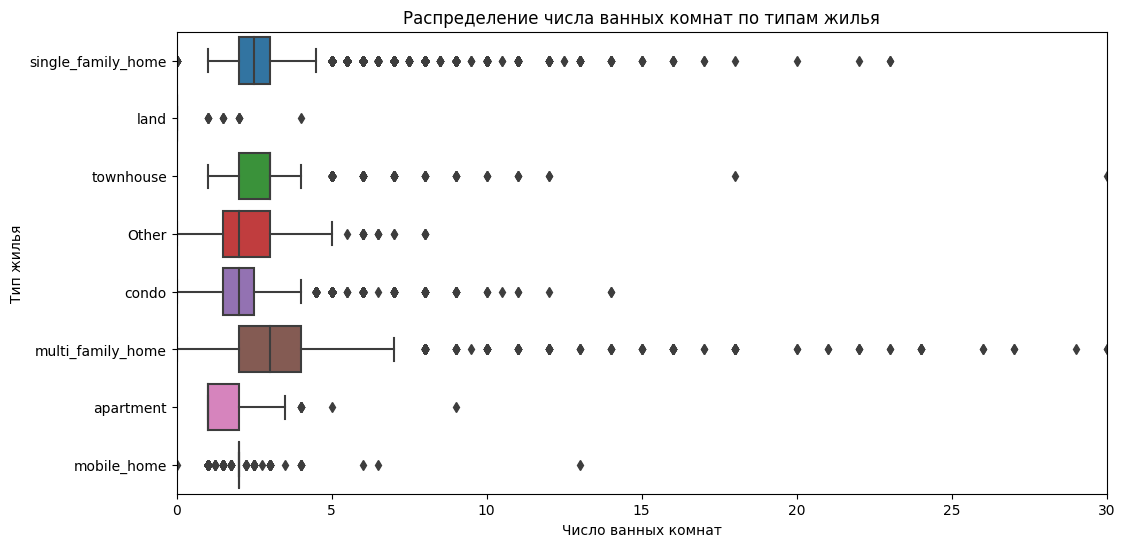

In [44]:
# Создаем фигуру
plt.figure(figsize=(12, 6))

# Создаем ящиковую диаграмму для разбивки числа ванных комнат по типам жилья
boxplot = sns.boxplot(
    data=df,
    x='baths',
    y='propertyType'
)

# Добавляем метки к осям
boxplot.set(xlabel='Число ванных комнат', ylabel='Тип жилья')

# Добавляем заголовок графика
boxplot.set_title('Распределение числа ванных комнат по типам жилья')

# Сделаем ограничения по x
boxplot.set(xlim=(0, 30))

# Отображаем график
plt.show()

Для каждого типа недвижимости медианное значение числа ванных комнат составляет примерно от 2 до 3 (за исключением земельных участков Land, где ванных комнат, как правило, не имеется).

Попробуем определить выбросы методом Тьюки, предварительно проверив данные на нормальность.

In [45]:
# Установим уровень значимости и подготовим сообщения о результатах
alpha = 0.05
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

# Проведем тест для признака ванных комнат
_, p = shapiro(df['baths'])
print('Результаты теста Шапиро-Уилка ')
print('p = %.3f' % p)

# Интерпретируем результаты
if p > alpha:
	print(H0)
else:
	print(Ha)

Результаты теста Шапиро-Уилка 
p = 1.000
Данные распределены нормально


In [46]:
# Функция определения выбросов по методу Тьюки
def outliers_iqr(data: pd.DataFrame,
                 feature: str) -> tuple:
    # Вычисляем квартили и межквартильное расстояние
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1

    # Определяем границы диапазона
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)

    # Определяем выбросы и очищенные записи
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]

    # Возвращем результат в виде кортежа датафреймов
    return outliers, cleaned

In [47]:
# Применим написанную функцию и выведем результаты ее работы на экран
outliers, cleaned = outliers_iqr(df, 'baths')

print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 10363
Результирующее число записей: 105669


In [48]:
outliers['baths'].value_counts().nlargest(3)

0.0    3849
5.0    2998
6.0    1239
Name: baths, dtype: int64

Метод Тьюки посчитал выбросами объекты недвижимости, где количество ванных комнат равно 0 или свыше 5, что логично.

Для цели заполнения пропущенных значений используем медиану для каждого из типа недвижимости.

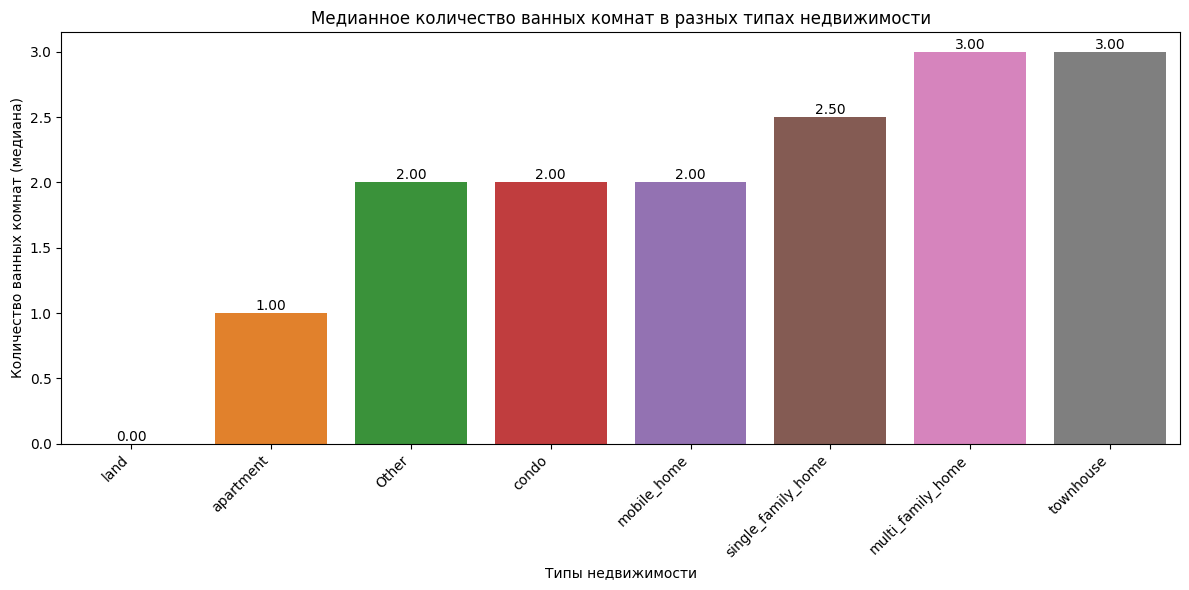

In [49]:
# Вычислим медианные значения ванных комнат для разных типов недвижимости
baths_pr = df.groupby('propertyType')['baths'].median().sort_values()

# Создаем фигуру с подходящим размером
plt.figure(figsize=(12, 6))

# Создаем столбчатую диаграмму
barplot = sns.barplot(
    data=baths_pr.to_frame().reset_index(),
    y='baths',
    x='propertyType'
)

# Добавляем аннотации с численными значениями медиан на столбцах
for index, row in baths_pr.reset_index().iterrows():
    barplot.text(index, row['baths'], f'{row["baths"]:.2f}', ha='center', va='bottom')

# Добавляем заголовок и метки к осям
barplot.set_title('Медианное количество ванных комнат в разных типах недвижимости')
barplot.set_xlabel('Типы недвижимости')
barplot.set_ylabel('Количество ванных комнат (медиана)')

# Уменьшаем наклон названий типов недвижимости на оси x
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right')

# Отображаем график
plt.tight_layout()
plt.show()

In [50]:
# Вычислим медианные значения ванных комнат для разных типов недвижимости
baths_pr = df.groupby('propertyType')['baths'].median()

# Заполняем пропуски в признаке "baths" медианными значениями для соответствующего типа недвижимости
df['baths'] = df['baths'].fillna(df['propertyType'].map(baths_pr))

# Проверяем, что все пропуски заполнены
print('Пропуски в признаке baths:', df['baths'].isna().sum())

Пропуски в признаке baths: 0


В заключении ещё раз сделаем визуализацию распределения признака, построив для этого диаграмму рассеяния и "ящик с усами"

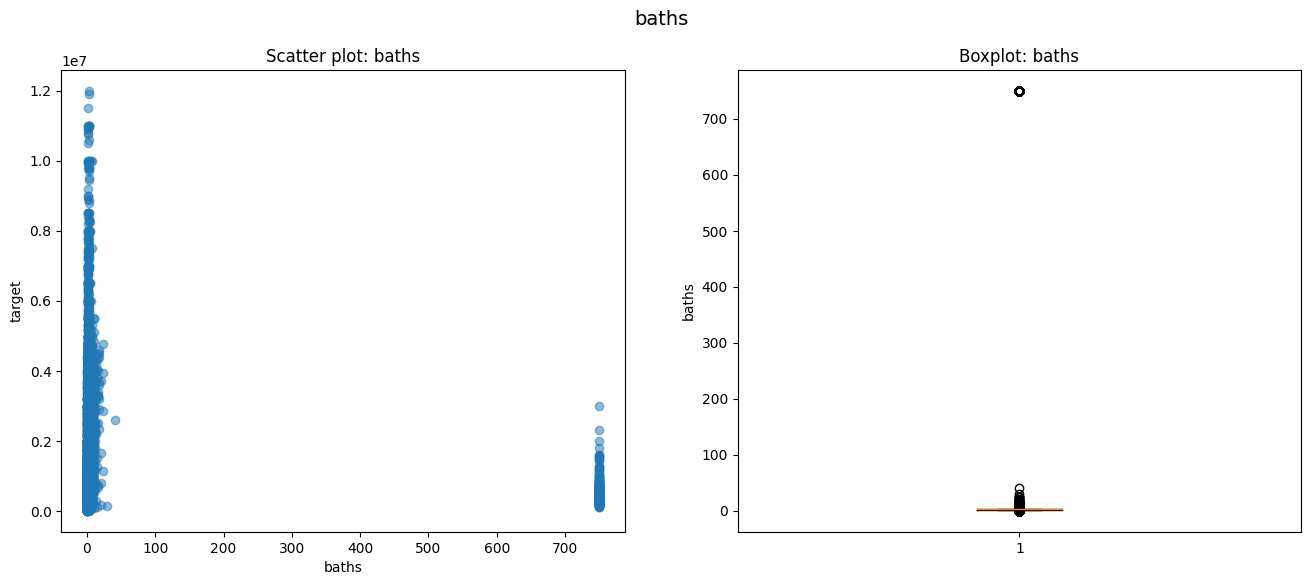

In [440]:
# Создание графиков рассеивания и ящиков с усами для столбца 'baths'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'baths', fontsize=14)

# График рассеивания
ax1.scatter(df['baths'], df['target'], alpha=0.5)
ax1.set_title(f'Scatter plot: baths')
ax1.set_xlabel('baths')
ax1.set_ylabel('target')

# Ящик с усами
ax2.boxplot(df['baths'])
ax2.set_title(f'Boxplot: baths')
ax2.set_ylabel('baths')

plt.show()

In [128]:
# Проверим количество объектов, у которых ванных больше, чем 10
baths_too_much = df[df['baths'] > 10].index
print(f'Свыше 10 ванных комнат насчитывается в {len(baths_too_much)} объектах')
print('Это составляет {:2.2%} датафрейма'.format(len(baths_too_much)/df.shape[0]))

# Удаляем эти записи и очищаем память
df.drop(baths_too_much, axis=0, inplace=True)
del baths_too_much

Свыше 10 ванных комнат насчитывается в 305 объектах
Это составляет 0.10% датафрейма


## Обработка признака "homeFacts"

Данный признак содержит следующую информацию об объектах недвижимости:

- Year built - год постройки,
- Remodeled year - год обновления,
- Heating - вид отопления,
- Cooling - вид охлаждения,
- Parking - наличие парковки,
- lotsize - размер участка,
- Price/sqft - цена за квадратный фут.

In [51]:
# посмотрим на пропуски
df.homeFacts.isna().sum()

0

Пропусков в данном признаке нет. 

Нам необходимо произвести десериализацию строки со словарем значений и создать новые признаки в DataFrame.

In [52]:
# функция десереализации
def deserialize_home(s: str) -> pd.Series:
    result = eval(s)['atAGlanceFacts']
    return pd.Series([r['factValue'] for r in result])

# Воспользуемся написанной функций, чтобы создать новые признаки из homeFacts
df[['yearBuilt', 'remodeledYear', 'heating', 'cooling',
    'parking', 'lotsize', 'price_sqft']] = df['homeFacts'].apply(deserialize_home)

In [53]:
# удаляем признак homeFacts
df = df.drop('homeFacts', axis=1)

## Обработка новых признаков

### Year built

Для определения возраста здания или участка, мы будем использовать наибольшее из двух доступных значений: года постройки или года обновления. Мы объединим два указанных признака и обработаем пустые значения, а затем сравним полученный год с текущим годом.

In [54]:
# посмотрим на пропуски
na_info = []  # Создаем пустой список для хранения информации о пропусках.

# Список признаков для анализа
features_to_check = ['yearBuilt', 'remodeledYear']  # Задаем список признаков, которые мы хотим анализировать.

for feature in features_to_check:
    # Считаем количество пропусков в каждом из выбранных признаков.
    na_count = df[feature].isna().sum() + df[df[feature] == ''].shape[0]
    # Рассчитываем долю пропусков относительно общего числа записей в DataFrame.
    na_share = round(na_count / df.shape[0] * 100, 2)
    # Сохраняем информацию о пропусках в виде кортежа и добавляем его в список na_info.
    na_info.append((feature, na_count, na_share))

# Выводим информацию о пропусках для каждого признака.
for feature, na_count, na_share in na_info:
    print(f'Количество пропусков в {feature} - {na_count}  или {na_share}%.')


Количество пропусков в yearBuilt - 61967  или 16.54%.
Количество пропусков в remodeledYear - 224731  или 60.0%.


In [55]:
# Функция для объединения годов с учетом нечисловых значений
def year_combination(b, r):
    # Преобразуем пустые значения в None
    if b in (None, '', np.nan):
        b = None
    if r in (None, '', np.nan):
        r = None

    # Проверяем, можно ли преобразовать значения в целые числа
    try:
        b = int(b) if b is not None else None
        r = int(r) if r is not None else None
    except ValueError:
        return None

    # Сравниваем годы и выбираем наибольший, или возвращаем None, если нет годов
    if b is None and r is None:
        return None
    elif b is None:
        return r
    elif r is None:
        return b
    else:
        return str(max(b, r))
    
# Создаем признак, объединяющий года с использованием функции
df['Year'] = df.apply(lambda row: year_combination(row['yearBuilt'], row['remodeledYear']), axis=1)

Вычислим медианное значение года постройки или обновления для разных типов недвижимости.

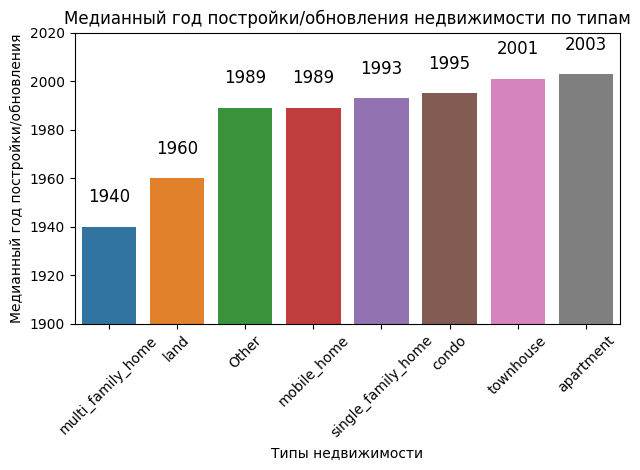

In [56]:
# Вычислим медианное значение года постройки или обновления для разных типов недвижимости
median_prop_year = df.groupby('propertyType')['Year'].median().sort_values()

# Отобразим медианы в виде диаграммы
barplot = sns.barplot(
    data = median_prop_year.to_frame().reset_index(),
    y = 'Year',
    x = 'propertyType'
);
# Добавляем аннотации к столбцам
for index, row in median_prop_year.reset_index().iterrows():
    barplot.text(index, row['Year'] + 10, int(row['Year']), ha='center', fontsize=12)

# Настройки графика
plt.title('Медианный год постройки/обновления недвижимости по типам')
plt.xlabel('Типы недвижимости')
plt.ylabel('Медианный год постройки/обновления')
plt.xticks(rotation=45)
plt.ylim(1900, 2020)
plt.tight_layout()

# Отображаем график
plt.show()

Данный график отображает реальную картину. Категории недвижимости типа townhouse, apartment и condo относятся к современным типам построек, в то время как дачные участки, дома для одной и нескольких семей к более архаичным.

Заполняем пропуски медианой в зависимости от типа недвижимости.

In [57]:
# Запускаем цикл по всем типам недвижимости
for property_type in median_prop_year.index:
    # Создаем маску, которая выбирает записи с определенным типом недвижимости
    mask_property_type = df['propertyType'] == property_type
    
    # Создаем маску для записей с пропущенным значением 'Year'
    mask_missing_last_year = df['Year'].isna()
    
    # Ищем индексы записей, которые удовлетворяют обеим маскам
    indices_to_fill = df[mask_property_type & mask_missing_last_year].index
    
    # Заполняем пропуски в столбце 'Year' медианными значениями для данного типа недвижимости
    df.loc[indices_to_fill, 'Year'] = median_prop_year[property_type]

# Приводим столбец 'Year' к целочисленному типу данных (int)
df['Year'] = df['Year'].astype(int)

# Проверяем, сколько пропусков осталось в признаке 'Year'
print('Осталось пропусков в признаке Year:', df['Year'].isna().sum())


Осталось пропусков в признаке Year: 0


Проведем анализ наличия выбросов в созданном признаке "год постройки/обновления". Для этой цели мы построим "ящик с усами".

Text(0, 0.5, 'Типы недвижимости')

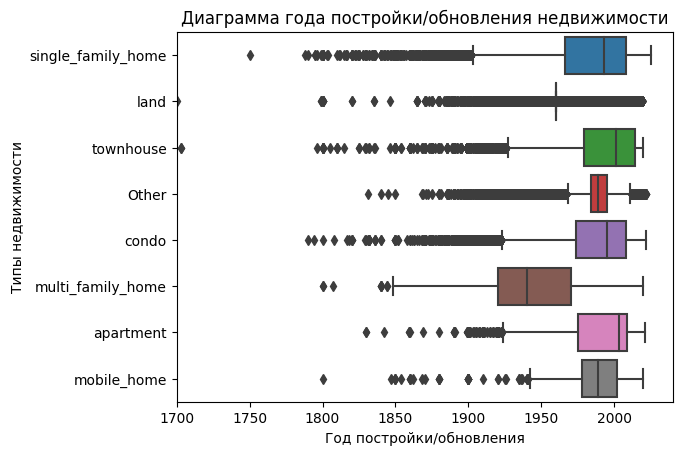

In [58]:
# Построим коробчатую диаграмму признака Year
boxplot = sns.boxplot(
    data = df,
    x = 'Year',
    y = 'propertyType'
);
boxplot.set(xlim=(1700,2040));
boxplot.set_title('Диаграмма года постройки/обновления недвижимости')
boxplot.set_xlabel('Год постройки/обновления')
boxplot.set_ylabel('Типы недвижимости')

Старейшие (колониальные) дома датируются 1600 годом. Верхним фильтром сделаем прошлый год (2022). Также создадим новый признак возраста объекта недвижимости.

In [59]:
# Заменяем выбросы медианой для каждого типа недвижимости
for property_type in median_prop_year.index:
    # Создаем маску, которая выбирает записи с определенным типом недвижимости
    property_mask = df['propertyType'] == property_type
    
    # Создаем маску для выбросов: записи с годом постройки недвижимости менее 1600 или более 2023
    outliers_mask = (df['Year'] < 1600) | (df['Year'] > 2023)
    
    # Находим индексы записей, которые удовлетворяют обеим маскам
    indices_to_replace = df[property_mask & outliers_mask].index
    
    # Заменяем выбросы (некорректные годы) в столбце 'Year' медианными значениями для данного типа недвижимости
    df.loc[indices_to_replace, 'Year'] = median_prop_year[property_type]

# Создаем новый признак "Возраст недвижимости"
df['age'] = 2023 - df['Year']

# Удаляем ненужные признаки: 'yearBuilt', 'remodeledYear', 'Year'
df.drop(['yearBuilt', 'remodeledYear', 'Year'], axis=1, inplace=True)

# Очищаем память от временных переменных
del median_prop_year, property_type, property_mask, outliers_mask, indices_to_replace

В заключении ещё раз сделаем визуализацию признака "age".

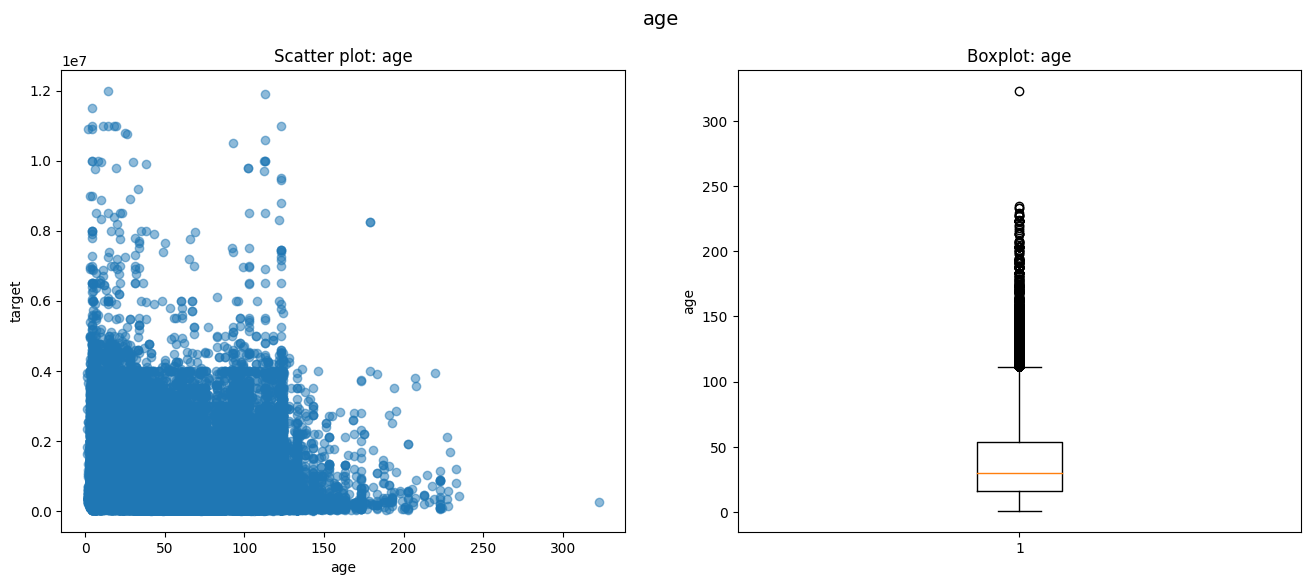

In [442]:
# Создание графиков рассеивания и ящиков с усами для столбца 'age'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'age', fontsize=14)

# График рассеивания
ax1.scatter(df['age'], df['target'], alpha=0.5)
ax1.set_title(f'Scatter plot: age')
ax1.set_xlabel('age')
ax1.set_ylabel('target')

# Ящик с усами
ax2.boxplot(df['age'])
ax2.set_title(f'Boxplot: age')
ax2.set_ylabel('age')

plt.show()

In [129]:
# Удалим объект старше 300 лет
age_too_old = df[df['age'] > 300].index
df.drop(age_too_old, axis=0, inplace=True)
del age_too_old

### Heating

Признак указывает нам на наличие или отсутсвие отопления. При этом в данном признаке множество пропущенных и уникальных значений.

In [60]:
# посмотрим на значения признака
df.heating.value_counts()

                                                                105039
Forced Air                                                       82354
Forced air                                                       51120
Other                                                            29064
Electric                                                         10170
                                                                 ...  
Exhaust Fans                                                         1
Central, Exhaust Fans, Natural Gas, Zoned                            1
BR Closet-Electric - new                                             1
Wood Stove                                                           1
Baseboard, Hot Water, Programmable Thermostat, Radiant Floor         1
Name: heating, Length: 1983, dtype: int64

In [61]:
# посмотрим на пропуски
df['heating'].isna().sum()

3485

In [62]:
# посмотрим на уникальные значения
df.heating.nunique()

1983

In [63]:
# Приводим значения к нижнему регистру
df['heating'] = df['heating'].str.lower()

Проведя небольшой анализ, мне удалось выяснить, что стоимость домов, оборудованных сисемой отопления выше, чем у аналогичных домов без отопления. Исходя из этой информации, я приняла решение сделать этот признак бинарным. Для домов, где значение признака 'Heating' равно пустой строке, 'no data' или 'none', мы устанавливаем значение 0, а для всех остальных значений - 1.

In [64]:
# Удаляем лишние одиночные кавычки в столбце 'heating'
df['heating'] = df['heating'].str.replace("'", '', regex=True)

# Создаем новый столбец 'heating_bin', который равен 1, если 'heating' не равен пустой строке
# или 0 в противном случае
df['heating_bin'] = df['heating'].apply(lambda x: 1 if x not in ['', 'no data', 'None', 'none'] else 0)

In [65]:
# сделаем проверку
df.heating_bin.value_counts()

1    261042
0    113522
Name: heating_bin, dtype: int64

In [66]:
df['heating_bin'].isna().sum()

0

In [67]:
# удалим признак 'heating'
df= df.drop('heating', axis=1)

### Cooling

В признаке большое число пропусков. Если значительная часть данных о кондиционерах отсутствуют, то, вероятно, можно сделать вывод, что в этих случаях кондиционеры не установлены или отсутствуют. Сделаем признак также бинарным, в зависимости от наличия кондиционера или иной системы охлаждения.

In [68]:
# посмотрим на значения признака
df.cooling.value_counts()

Central                                                                               157626
                                                                                      119464
Central Air                                                                            14382
No Data                                                                                10395
Has Cooling                                                                             9729
                                                                                       ...  
Air Conditioning-Room, Evaporative Cooler (Swamp)                                          1
Central Air, Electric Hot Air, Heat Pump for Heat, Multi-Zone A/C, Multi-Zone Heat         1
Forced Air Heating, Radiator Heat, Wall Heat                                               1
Air Conditioning, Dual                                                                     1
Central A/C (Gas), Central Heat (Gas), Heat Pump                      

In [69]:
# посмотрим на пропуски
df['cooling'].isna().sum()

3485

In [70]:
# посмотрим на уникальные значения
df.cooling.nunique()

1444

In [71]:
# Приводим значения к нижнему регистру
df['cooling'] = df['cooling'].str.lower()

In [72]:
# Удаляем лишние одиночные кавычки в столбце 'cooling'
df['cooling'] = df['cooling'].str.replace("'", '', regex=True)

# Создаем новый столбец 'cooling_bin', который равен 1, если 'cooling' не равен пустой строке
# или 0 в противном случае
df['cooling_bin'] = df['cooling'].apply(lambda x: 1 if x not in ['', 'no data', 'None', 'none'] else 0)

In [73]:
# сделаем проверку
df.cooling_bin.value_counts()

1    237414
0    137150
Name: cooling_bin, dtype: int64

In [74]:
# удалим признак 'cooling'
df= df.drop('cooling', axis=1)

### Parking

Аналогично признакам heating и cooling, сделаем признак Parking бинарным, в зависимости от наличия парковки. Пропуски будем считать отсутствием парковки.

In [75]:
# посмотрим на значения признака
df.parking.value_counts()

                                                                                                                                    170902
Attached Garage                                                                                                                      70240
2 spaces                                                                                                                             27865
1 space                                                                                                                              14109
Detached Garage                                                                                                                      13093
                                                                                                                                     ...  
Boat, Driveway, Garage Door Opener, Garage Faces Rear, Oversized, Workshop in Garage                                                     1
Assigned, Open, Under Build

In [76]:
# посмторим на пропуски
df['parking'].isna().sum()

3485

In [77]:
# Приводим значения к нижнему регистру
df['parking'] = df['parking'].str.lower()

In [78]:
# Удаляем лишние одиночные кавычки в столбце 'parking'
df['parking'] = df['parking'].str.replace("'", '', regex=True)

# Создаем новый столбец 'parking_bin', который равен 1, если 'parking' не равен пустой строке
# или 0 в противном случае
df['parking_bin'] = df['parking'].apply(lambda x: 1 if x not in ['', 'no data', 'None', 'none'] else 0)

In [79]:
# сделаем проверку
df.parking_bin.value_counts()

1    188296
0    186268
Name: parking_bin, dtype: int64

In [80]:
# удалим признак 'parking'
df = df.drop('parking', axis=1)

### Lotsize

Этот признак содержит размер участка. 

In [81]:
# посмотрим какие значения он принимает
df.lotsize.value_counts()

                  32856
—                 25178
No Data            5295
-- sqft lot        3813
0.26 acres         2481
                  ...  
36962                 1
5752                  1
6,816 Sq. Ft.         1
8,762 sqft            1
7,084 sqft lot        1
Name: lotsize, Length: 37332, dtype: int64

In [82]:
# посмотрим на пропуски
df['lotsize'].isna().sum()

28161

В признаке огромное количество пропусков. При этом он выражен в акрах и в других единицах измерения. Акр равен 43,5 тыс. квадратных футам, а в нашем датафрейме встречаются цифры, выраженные в десятках тысяч, что означает другую размерность, либо выбросы.Заполнение множества пропусков числового признака случайными значениями только ухудшит наше предсказание, удалим этот признак.   

In [83]:
# удалим признак 'lotsize'
df = df.drop('lotsize', axis=1)

## Обработка признака "state"

Данный признак содержит аббревиатуру штата, в котором находится тот или иной объект недвижимости.

In [84]:
# посмотрим на уникальные значения
df.state.unique()

array(['NC', 'WA', 'CA', 'TX', 'FL', 'PA', 'TN', 'IA', 'NY', 'OR', 'DC',
       'NV', 'AZ', 'GA', 'IL', 'NJ', 'MA', 'OH', 'IN', 'UT', 'MI', 'VT',
       'MD', 'CO', 'VA', 'KY', 'MO', 'WI', 'ME', 'MS', 'OK', 'SC', 'MT',
       'DE', 'Fl', 'BA', 'AL', 'OT', 'OS'], dtype=object)

Аббревиатуры 'OT', 'OS', 'BA', и 'AL' не соответствуют штатам США и являются ошибками в данных. Штат 'Fl' скорее всего соответствует Флориде (FL). Произведём замену и удаление некорректных записей штатов.

In [85]:
# Создаем список с штатами, которые нужно удалить
states_to_remove = ['BA', 'OS', 'OT', 'Al']

# Фильтруем DataFrame: оставляем только записи, где значение в столбце 'state' не находится в списке states_to_remove
df = df[~df['state'].isin(states_to_remove)]


In [86]:
# Заменяем значение 'Fl' на 'FL' в столбце 'state'
df['state'] = df['state'].replace('Fl', 'FL')

## Обработка признака "beds"

В этом признаке содержится информация о количестве спален, представленная либо в числовом формате, либо в виде текстовой записи "n  Beds", где "n" представляет собой количество спален. Все остальные записи либо пусты, либо не содержат необходимой информации.

In [87]:
# посмотрим на уникальные значения
df.beds.unique()

array(['4', '3 Beds', '5 Beds', ..., '2.72 acres', '9,565 sqft',
       '8,479 sqft'], dtype=object)

Для начала выделим число спален из данного признака и посмотрим на пропущенные значения.

In [88]:
def beds_num(s: str) -> float:
    if isinstance(s, str):
        # Если значение является строкой
        try:
            # Попытка преобразовать строку в число, игнорируя буквы и символы
            return float(re.search(r'(\d+(\.\d+)?)', s).group(1))
        except (AttributeError, ValueError):
            return np.nan  # Если не удалось извлечь число, вернуть NaN
    else:
        return np.nan  # Если значение не является строкой, вернуть NaN

# Применяем написанную функцию для выделения числа спален
df['beds'] = df['beds'].apply(beds_num)

# Проверяем долю пустых значений
print('Доля пустых значений в признаке beds: {:2.2%}'.format(df['beds'].isna().mean()))

Доля пустых значений в признаке beds: 28.88%


Пропусков довольно много, заполним их медианным значением для каждого типа недвижимости. Но сперва исследуем выбросы и аномальные значения.

In [89]:
# Установим уровень значимости и подготовим сообщения о результатах
alpha = 0.05
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

# Проведем тест для признака спальных комнат
_, p = shapiro(df['beds'])
print(' Результаты теста Шапиро-Уилка ')
print('p = %.3f' % p)

# Интерпретируем результаты
if p > alpha:
	print(H0)
else:
	print(Ha)

 Результаты теста Шапиро-Уилка 
p = 1.000
Данные распределены нормально


In [90]:
# Воспользуемся ранее написанной функцией для определения выбросов
outliers, cleaned = outliers_iqr(df, 'beds')

print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print('Процент выбросов в исходном датафрейме: {:2.2%}'.format(outliers.shape[0]/df.shape[0]))
display('ТОП-5 по количеству спален среди выбросов:',
    outliers['beds'].value_counts().nlargest(5))

Число выбросов по методу Тьюки: 20611
Результирующее число записей: 245779
Процент выбросов в исходном датафрейме: 5.50%


'ТОП-5 по количеству спален среди выбросов:'

6.0    6736
1.0    6153
7.0    2028
0.0    1430
8.0    1317
Name: beds, dtype: int64

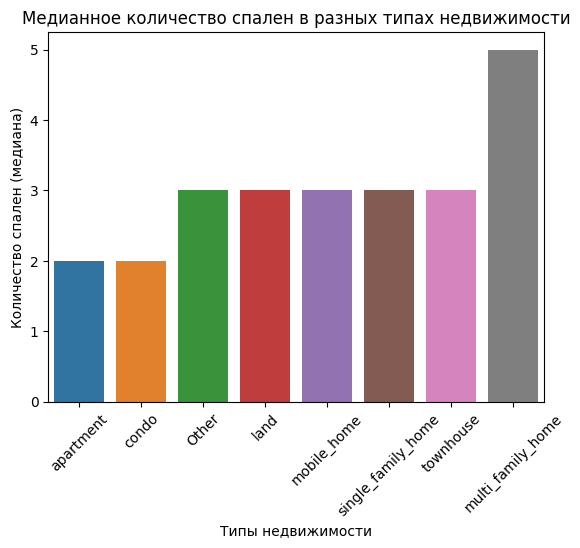

In [91]:
# Вычислим медианное значение спален для разных типов недвижимости
beds_pr = df.groupby('propertyType')['beds'].agg('median').sort_values()

# Отобразим медианы в виде диаграммы
barplot = sns.barplot(
    data = beds_pr.to_frame().reset_index(),
    y = 'beds',
    x = 'propertyType'
);
barplot.set_title('Медианное количество спален в разных типах недвижимости');
barplot.set_xlabel('Типы недвижимости');
barplot.set_ylabel('Количество спален (медиана)');
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45);

Заполним пропуски медианным значением количества спален для каждой категории недвижимости.

In [92]:
# Вычисляем медианное количество спален для каждой категории недвижимости
median_beds_by_property_type = df.groupby('propertyType')['beds'].transform('median')

# Заполняем пропуски в столбце 'beds' медианными значениями для соответствующей категории недвижимости
df['beds'] = df['beds'].fillna(median_beds_by_property_type)

# Проверяем, что все пропуски заполнены
print('Осталось пропусков в признаке beds:', df['beds'].isna().sum())

Осталось пропусков в признаке beds: 0


Посмтотрим на график рассеивания и коробчатую диаграмму для признака 'beds'.

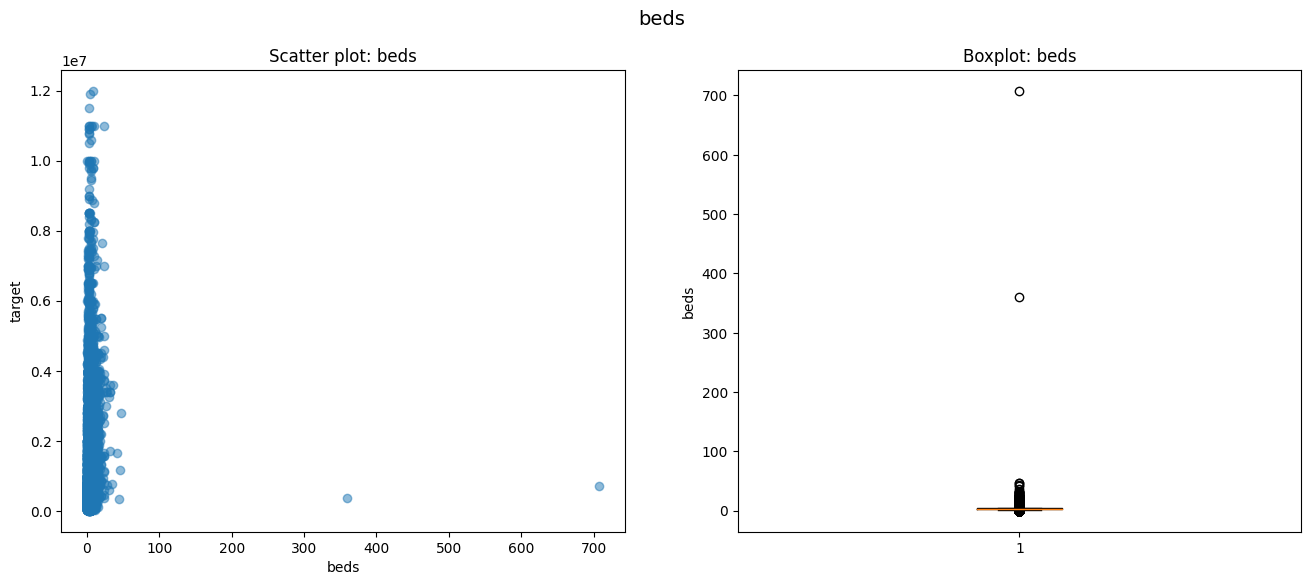

In [445]:
# Создание графиков рассеивания и ящиков с усами для столбца 'beds'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'beds', fontsize=14)

# График рассеивания
ax1.scatter(df['beds'], df['target'], alpha=0.5)
ax1.set_title(f'Scatter plot: beds')
ax1.set_xlabel('beds')
ax1.set_ylabel('target')

# Ящик с усами
ax2.boxplot(df['beds'])
ax2.set_title(f'Boxplot: beds')
ax2.set_ylabel('beds')

plt.show()

In [130]:
# Проверим количество объектов, у которых количество спален больше 10
beds_too_much = df[df['beds'] > 10].index
print(f'Свыше 10 спален насчитывается в {len(beds_too_much)} объектах')
print('Это составляет {:2.2%} всего датафрейма'.format(len(beds_too_much)/df.shape[0]))

# Удаляем эти записи и очищаем память
df.drop(beds_too_much, axis=0, inplace=True)
del beds_too_much

Свыше 10 спален насчитывается в 483 объектах
Это составляет 0.15% всего датафрейма


## Обработка признака "zipcode"

Признак'zipcode' содержит информацию о почтовом индексе объекта недвижимости.

In [93]:
# количество уникальных значений
df.zipcode.nunique()

4540

In [94]:
# количество пропусков
df.zipcode.isna().sum()

0

Пропусков в признаке нет, исследуем уникальные значения на предмет наличия некорректных записей.

In [95]:
df.zipcode.sort_values().unique()[:40]

array(['--', '0', '02108', '02109', '02110', '02111', '02113', '02114',
       '02115', '02116', '02118', '02119', '02120', '02121', '02122',
       '02124', '02125', '02126', '02127', '02128', '02129', '02130',
       '02131', '02132', '02134', '02135', '02136', '02199', '02210',
       '02215', '02467', '04666', '04901', '04937', '04957', '04963',
       '05345', '05441', '05441-4400', '05443'], dtype=object)

In [96]:
# посмотрим на записи, где zipcode равен '--'
df[df.zipcode=='--']

,status,propertyType,street,baths,city,schools,sqft,zipcode,beds,state,target,private_pool,new_fireplace,price_sqft,age,heating_bin,cooling_bin,parking_bin
231282,New,Other,0 N Gopher Canyon Rd,2.0,bonsall,"[{'rating': ['7/10', '7/10', '3/10'], 'data': ...",NaN,--,449.0,CA,"$60,000,000",0,0,,34,0,0,0
235207,Other,townhouse,1744 N Dixie Hwy # 1744,3.0,fort lauderdale,"[{'rating': ['3/10', '5/10', '7/10'], 'data': ...","2,043",--,3.0,FL,"$425,000",0,0,$208,13,1,1,0


Запись всего одна, удалим её.

In [97]:
df = df.drop([235207])

In [98]:
# посмотрим на записи, где zipcode равен '0'
df[df.zipcode=='0']

,status,propertyType,street,baths,city,schools,sqft,zipcode,beds,state,target,private_pool,new_fireplace,price_sqft,age,heating_bin,cooling_bin,parking_bin
30261,Active,land,Gates Canyon Rd,0.0,vacaville,"[{'rating': ['7', '4', '6', '6', '10', '2'], '...",0,0,3.0,CA,"$380,000",0,0,None,63,0,0,0
83522,New,single_family_home,Cornejo Ricardo Descalzi,2.5,quito ecuador,"[{'rating': [], 'data': {'Distance': [], 'Grad...",NaN,0,3.0,NY,"470,000",0,0,None,28,0,1,0
305572,For Sale,land,000 U.S. Hwy 359,0.0,laredo,"[{'rating': ['4/10'], 'data': {'Distance': ['7...","243,849 sqft",0,3.0,TX,"$1,740,000",0,0,$7/sqft,63,0,0,0


In [99]:
# удалим эти 3 строки
df = df.drop([30261, 83522, 305572])

Ещё есть индексы из двух чисел через дефис.

In [100]:
df[df.zipcode=='05441-4400']

,status,propertyType,street,baths,city,schools,sqft,zipcode,beds,state,target,private_pool,new_fireplace,price_sqft,age,heating_bin,cooling_bin,parking_bin
281307,Active,single_family_home,1331 Waterville Mountain Rd,2.5,bakersfield,"[{'rating': ['6', '2'], 'data': {'Distance': [...","2,745",05441-4400,3.0,VT,"695,000",0,0,$253 / Sq. Ft.,20,1,1,0


Как мне удалось выяснить, только первая часть обозначает индекс объекта, так что оставим только её.

In [101]:
# Уберём всё, что после дефиса
df.zipcode = df.zipcode.str.replace("-.+",'', regex=True)

## Обработка признака "street"

Признак "street" содержит информацию об адресе объекта недвижимости.

In [102]:
# уникальные значения
df.street.nunique()

334745

In [103]:
# посмотрим на пропуски
df.street.isna().sum()

2

In [104]:
# удаляем строки, где есть пропуски в столбце street
df = df.dropna(subset=['street'])

Данный признак малоинформативен, слишком много уникальных значений. Эта информация мало пригодна для построения модели.
Было бы намного лучше использовать информацию о конкретном районе. Эти сведения больше влияют на цену объекта недвижимости, так же тем самым нам удалось бы сократить количество уникальных значений. Процесс выделения района из адреса чересчур трудоёмкий, поэтому данный признак я удалю.

In [105]:
# удалим этот признак
df = df.drop('street', axis=1)

## Обработка признака "sqft"

Признак "sqft" содержит информацию о площади объекта недвижимости в футах. 

In [106]:
# посмотрим какие значения может принимать признак
df.sqft.value_counts()

0                                          11817
1,200 sqft                                   829
1,000 sqft                                   648
1,100 sqft                                   570
1,800 sqft                                   562
                                           ...  
Total interior livable area: 5,150 sqft        1
12,160 sqft                                    1
18,400 sqft                                    1
7,162 sqft                                     1
Total interior livable area: 4,615 sqft        1
Name: sqft, Length: 25371, dtype: int64

In [107]:
# посмотрим на пропущенные значения
df.sqft.isna().sum()

40078

Мы преобразуем этот признак в числовой формат, но не будем удалять пропущенные значения. С помощью признака price/sqft ("цена за квадратный фут"), который мы создали в результате десериализации "homefacts", мы сможем восстановить некоторые из пропущенных значений.

In [108]:
def sqft_number(s: str) -> float:
    if pd.isna(s):
        return np.NaN

    # Используем регулярное выражение для поиска числа
    match = re.search(r'(\d+)', s)
    if match:
        return float(match.group(1))
    else:
        return np.NaN

# Сначала избавимся от запятых, отделяющих тысячные разряды
df['sqft'] = df['sqft'].str.replace(',', '')

# Затем воспользуемся написанной функцией, чтобы выделить квадратные футы
df['sqft'] = df['sqft'].apply(sqft_number)

# Заменяем нулевые значения на пропуски
df['sqft'].replace(0, np.NaN, inplace=True)

## Обработка признака "schools"

В данном признаке содержится набор данных, связанных с ближайшими школами: рейтинг школы (по шкале 1-10), расстояние от объекта недвижимости до школы (в милях), тип школы (начальная, средняя и подготовительная) и название школы.

In [109]:
# посморим какие значения может принимать признак
df.schools[5]

"[{'rating': [], 'data': {'Distance': [], 'Grades': []}, 'name': []}]"

Считаю самыми ценными сведения о среднем расстоянии до ближайшей школы и среднем рейтинге школы в районе. Преобразуем наш исходный признак в два новых с полезной информацией о школах.

In [110]:
# Функция для обработки рейтинга школы
def about_rating(rating):
    rating = rating[0].replace('/10', '')  # Убираем '/10' из рейтинга
    extracted_numbers = [float(num) for num in rating if num.isdigit()]  # Извлекаем числа из строки
    average_rating = np.average(extracted_numbers) if extracted_numbers else 0  # Рассчитываем средний рейтинг
    return round(average_rating, 1)

# Применяем функцию к столбцу 'schools' и создаем новый столбец 'school_rating'
df['school_rating'] = (
    df['schools']
    .str.findall(r"'rating': ([\s\S]+?), 'data'")
    .apply(lambda x: about_rating(x))
)

# Заполняем пропущенные значения в 'school_rating' значением 0
df['school_rating'].fillna(0, inplace=True)

In [111]:
# Рассчитываем минимальную дистанцию до школ

# Извлекаем строку, содержащую расстояние до школы, с использованием регулярного выражения
min_distance = df.schools.str.findall(r"\bDistance': ([\s\S]+?), 'Grades\b")

# Извлекаем первое найденное значение из списков, полученных в предыдущем шаге
min_distance = min_distance.apply(lambda x: x[0])

# Удаляем все символы алфавита из расстояний с использованием регулярного выражения
min_distance = min_distance.str.replace('[a-zA-Z]', '', regex=True)

# Извлекаем числа, включая десятичные значения, из строк в формате число
min_distance = min_distance.str.findall(r'\b([0-9]+.[0-9]+)')

# Конвертируем каждое числовое значение из списка в тип float
min_distance = min_distance.apply(lambda x: [float(i) for i in x])

# Находим минимальное значение в каждом списке min_distance, и если список пустой, возвращаем -1
school_distance = min_distance.apply(lambda x: -1 if len(x) == 0 else min(x))

# Создаем новый признак 'school_distance' в нашем наборе данных и заполняем его вычисленными значениями.
# Пропуски заполняются значением -1
df['school_distance'] = school_distance

In [112]:
# признак schools можно удалить
df.drop('schools', axis=1, inplace=True)

Посмотрим на визуализацию признака 'school_distance'.

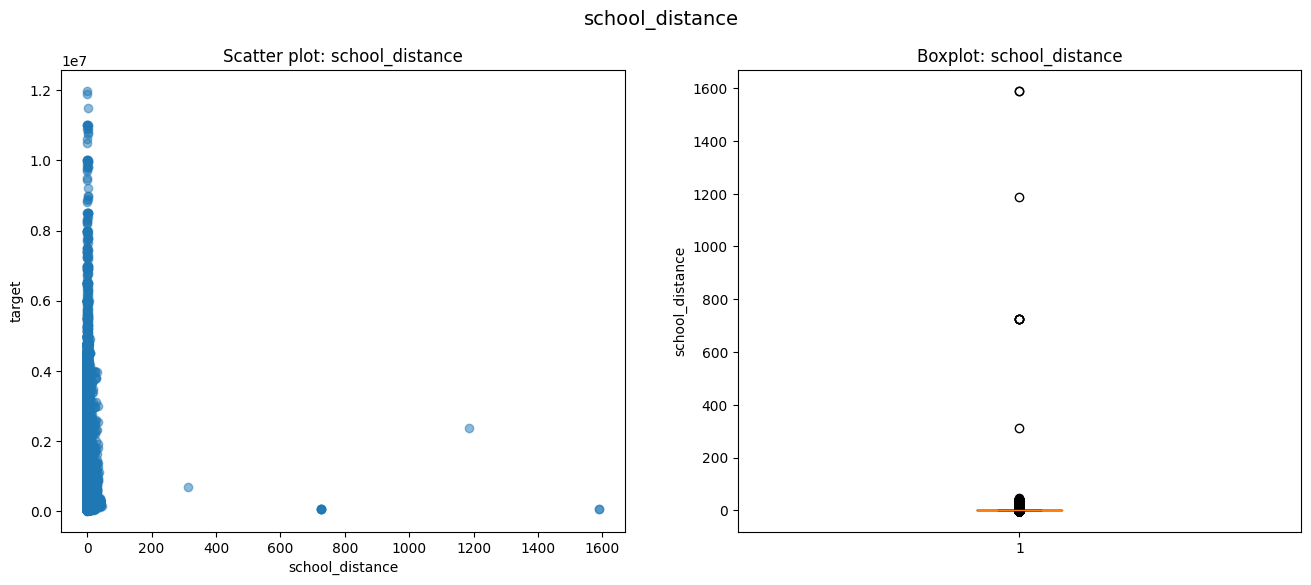

In [447]:
# Создание графиков рассеивания и ящиков с усами для столбца 'school_distance'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'school_distance', fontsize=14)

# График рассеивания
ax1.scatter(df['school_distance'], df['target'], alpha=0.5)
ax1.set_title(f'Scatter plot: school_distance')
ax1.set_xlabel('school_distance')
ax1.set_ylabel('target')

# Ящик с усами
ax2.boxplot(df['school_distance'])
ax2.set_title(f'Boxplot: school_distance')
ax2.set_ylabel('school_distance')

plt.show()

In [131]:
# Удалим объекты с расстоянием больше 200
distance_too_far = df[df['school_distance'] > 200].index
df.drop(distance_too_far, axis=0, inplace=True)
del distance_too_far

## Обработка признака "target"

Целевой признак, который представляет стоимость объекта недвижимости в долларах США, будет подвергнут предварительной очистке от символа валюты, запятых в числах и знака плюс в конце строки, после чего будет преобразован в целочисленный формат. Затем мы проведем анализ на наличие возможных выбросов, учитывая тип жилья при группировке данных.

In [113]:
# Очищаем признак target от символов '$', ',' и '+', затем преобразуем в целые числа
df['target'] = df['target'].str.replace('[^\d]', '', regex=True).astype(int)

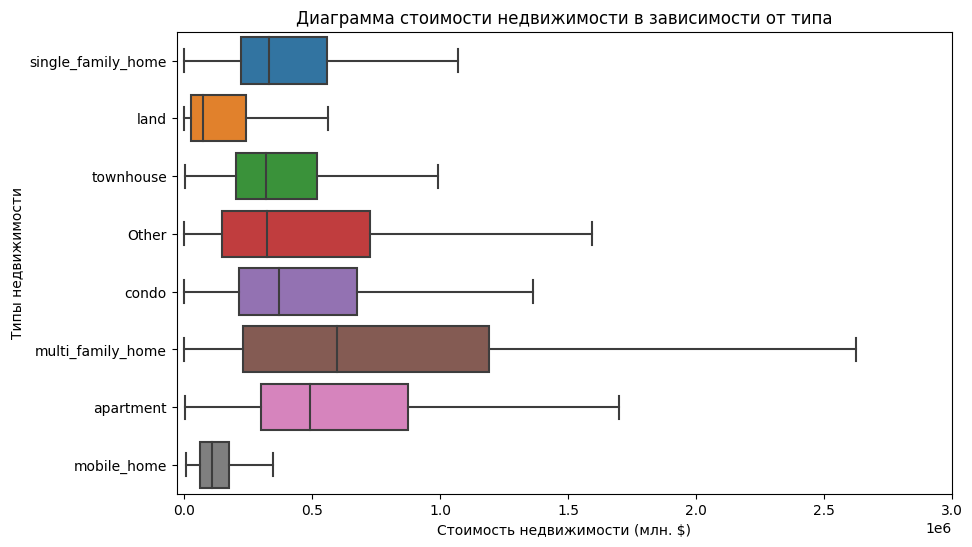

In [114]:
# Построим диаграмму целевого признака с разбивкой на типы жилья
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='target', y='propertyType', showfliers=False)
plt.xlim(-30000, 3000000)

plt.title('Диаграмма стоимости недвижимости в зависимости от типа')
plt.xlabel('Стоимость недвижимости (млн. $)')
plt.ylabel('Типы недвижимости')
plt.show()

Попробуем пролагорифмировать целевой признак.

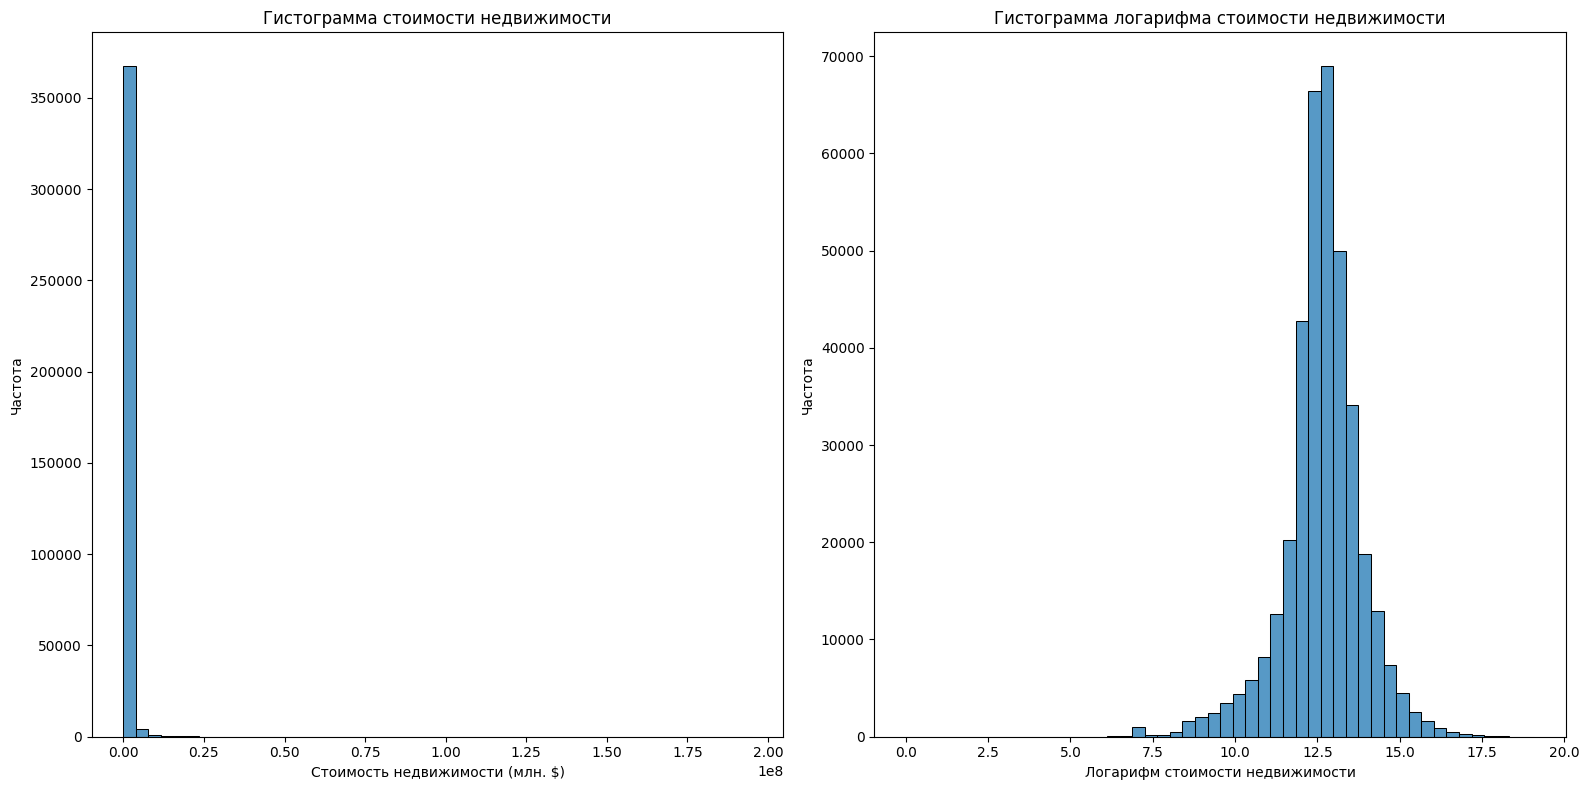

In [115]:
# Создаем сетку из двух графиков
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Гистограмма исходного признака
sns.histplot(data=df, x='target', bins=50, ax=axes[0])
axes[0].set_title('Гистограмма стоимости недвижимости')
axes[0].set_xlabel('Стоимость недвижимости (млн. $)')
axes[0].set_ylabel('Частота')

# Гистограмма признака в логарифмическом масштабе
log_target = np.log(df['target'])
sns.histplot(data=log_target, bins=50, ax=axes[1])
axes[1].set_title('Гистограмма логарифма стоимости недвижимости')
axes[1].set_xlabel('Логарифм стоимости недвижимости')
axes[1].set_ylabel('Частота')

plt.tight_layout()
plt.show()

В результате логарифмирования удалось приблизить распределение целевого признака к нормальному, что может улучшить работу модели. Для выявления выбросов я решила использовать метод z-отклонений (трех сигм).

In [116]:
# Функция определения выбросов по методу z-отклонений (трех сигм)
def outliers_z_score(df: pd.DataFrame,
                     feature: str,
                     log_scale: bool = True,
                     left: int = 3,
                     right: int = 3) -> tuple:
    # Если требуется переход к логарифмическому масштабу
    if log_scale:
        if df[feature].min() > 0: # если значения признака больше 0
            x = np.log(df[feature])
        else:
            x = np.log(df[feature]+1) # иначе добавляем единицу
    else:
        x = df[feature]

    # Вычисляем математическое ожидание и стандартное отклонение
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma

    # Определяем выбросы и очищенные данные
    outliers = df[(x < lower_bound) | (x > upper_bound)]
    cleaned = df[(x > lower_bound) & (x < upper_bound)]

    # Возвращаем кортеж из pd.DataFrame
    return outliers, cleaned

Вычислим выбросы для каждого типа недвижимости, немного "смягчив" верхнюю и нижнюю границы до 2.5 стандартных отклонений.

In [117]:
properties = list(df['propertyType'].unique())
borders = [(2.5, 2.5), (2.5, 2.5), (2.5, 2.5), (2.5, 2.5), (2.5,2.5), (2.5,2.5), (2.5,2.5), (2.5,2.5)] 
property_bound = dict(zip(properties, borders))
df['outliers'] = 0
for i, prop_type in enumerate(property_bound):
    outliers, cleaned = outliers_z_score(df = df[df['propertyType'] == prop_type],
                                         feature = 'target',
                                         log_scale = True,
                                         left = property_bound[prop_type][0],
                                         right = property_bound[prop_type][1])

    print(f'Число выбросов по методу z-отклонений для {prop_type}: {outliers.shape[0]}')
    print(f'Результирующее число записей для {prop_type}: {cleaned.shape[0]}\n')
    df.loc[outliers.index, 'outliers'] = 1
print(f'Всего по методу z-отклонений выявлено {df.outliers.sum()} выбросов.')

Число выбросов по методу z-отклонений для single_family_home: 5192
Результирующее число записей для single_family_home: 206134

Число выбросов по методу z-отклонений для land: 314
Результирующее число записей для land: 31080

Число выбросов по методу z-отклонений для townhouse: 419
Результирующее число записей для townhouse: 18075

Число выбросов по методу z-отклонений для Other: 817
Результирующее число записей для Other: 37950

Число выбросов по методу z-отклонений для condo: 1324
Результирующее число записей для condo: 53964

Число выбросов по методу z-отклонений для multi_family_home: 253
Результирующее число записей для multi_family_home: 12091

Число выбросов по методу z-отклонений для apartment: 62
Результирующее число записей для apartment: 2895

Число выбросов по методу z-отклонений для mobile_home: 82
Результирующее число записей для mobile_home: 3903

Всего по методу z-отклонений выявлено 8463 выбросов.


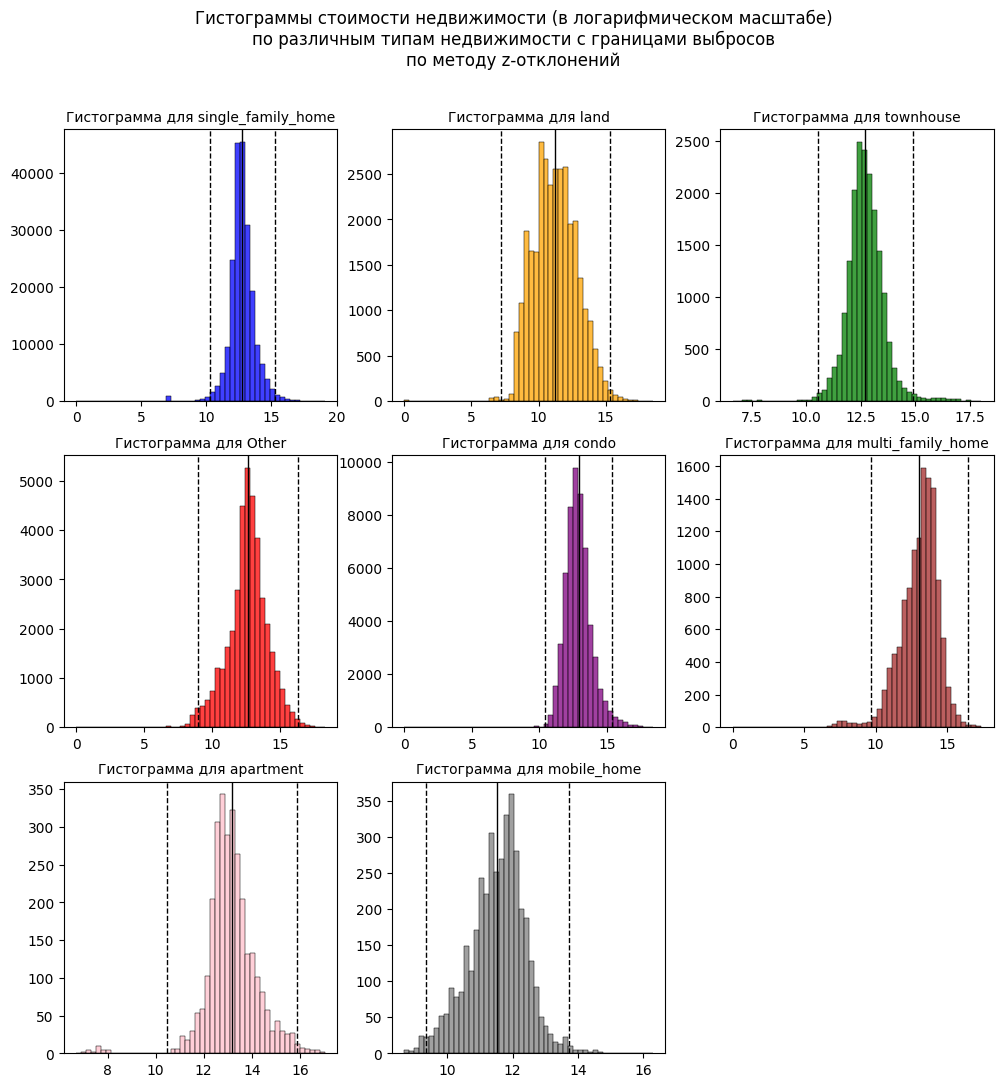

In [118]:
# Создаем 3x3 сетку для гистограмм
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
fig.suptitle('Гистограммы стоимости недвижимости (в логарифмическом масштабе)\n'+
             'по различным типам недвижимости с границами выбросов\n'+
             'по методу z-отклонений', fontsize=12);

# Создаем список цветов для гистограмм
hist_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

# Проходим циклом по типам недвижимости и строим гистограммы с границами выбросов
for i, prop_type in enumerate(property_bound):
    # Применяем логарифмическое преобразование, если значения > 0
    if df[df['propertyType'] == prop_type]['target'].min() > 0:
        log_target = np.log(df[df['propertyType'] == prop_type]['target'])
    else:
        log_target = np.log(df[df['propertyType'] == prop_type]['target']+1)

    # Вычисляем границы выбросов
    upper_bound = log_target.mean() + property_bound[prop_type][1] * log_target.std()
    lower_bound = log_target.mean() - property_bound[prop_type][0] * log_target.std()

    # Строим гистограмму для каждого типа недвижимости
    histplot = sns.histplot(
        data=log_target,
        bins=50,
        ax=axes[divmod(i, 3)[0], divmod(i, 3)[1]], 
        color=hist_colors[i]
    )
    
    # Добавляем вертикальные линии для среднего значения и границ выбросов
    histplot.axvline(log_target.mean(), color='k', lw=1)
    histplot.axvline(upper_bound, color='k', ls='--', lw=1)
    histplot.axvline(lower_bound, color='k', ls='--', lw=1)
    
    histplot.set_title(f'Гистограмма для {prop_type}', fontsize=10)
    histplot.set_xlabel('')
    histplot.set_ylabel('')

# Удаляем последний, неиспользуемый subplot
fig.delaxes(axes[2, 2])

Изучая гистограммы, можно заметить, что типы недвижимости "Land", "Multifamily" и "Mobile home" менее похожи на нормальные распределения. 

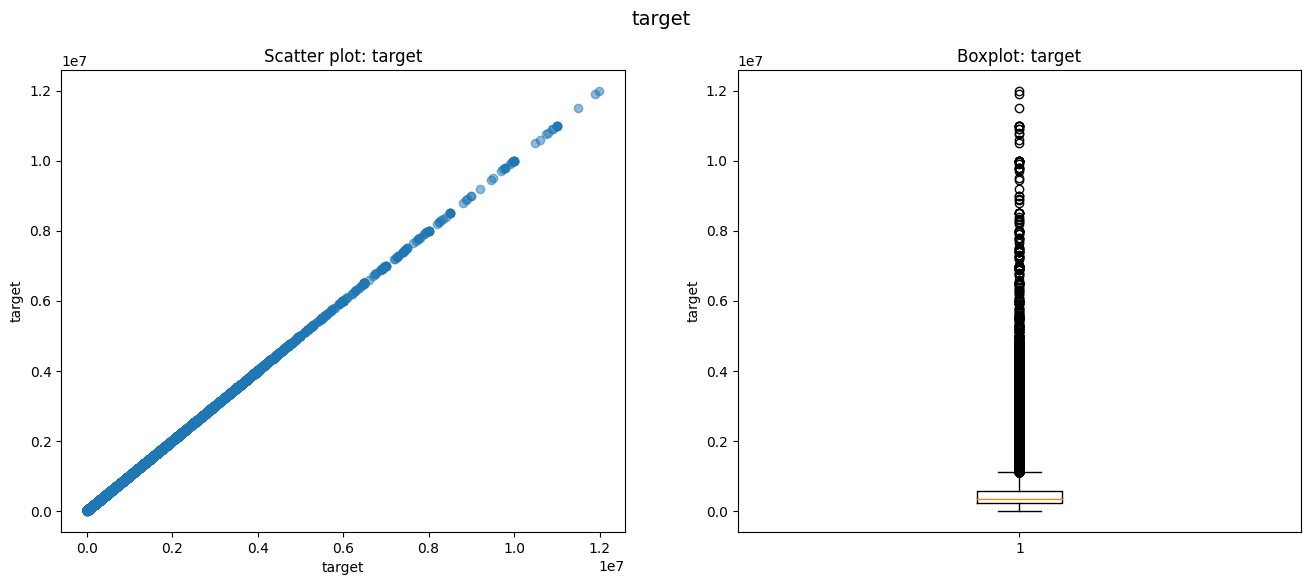

In [449]:
# Создание графиков рассеивания и ящиков с усами для столбца 'target'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'target', fontsize=14)

# График рассеивания
ax1.scatter(df['target'], df['target'], alpha=0.5)
ax1.set_title(f'Scatter plot: target')
ax1.set_xlabel('target')
ax1.set_ylabel('target')

# Ящик с усами
ax2.boxplot(df['target'])
ax2.set_title(f'Boxplot: target')
ax2.set_ylabel('target')

plt.show()

In [132]:
# Удалим объекты стоимостью выше 10 миллионов
target_too_high = df[df['target'] > 10000000].index
df.drop(target_too_high, axis=0, inplace=True)
del target_too_high

## Обработка признака "price_sqft"

Мы приведем признак к числовому формату, удалив из него текст и оставив только цены за квадратный фут, а также заменим все нули на значения NaN. В столбце существуют значения, которые совпадают с полной стоимостью недвижимости, что явно является ошибкой, их мы тоже удалим.

Далее мы вычислим площадь недвижимости, разделив стоимость "target" на цену за квадратный фут "price_sqft", создав новый временный признак. Из этого признака мы заменим пропуски в "sqft".

In [119]:
# Удаление символов "$", запятых и точек из столбца 'price_sqft'
df['price_sqft'] = df['price_sqft'].str.replace('[\$,\.]', '', regex=True)

# Воспользуемся написанной ранее функцией, чтобы выделить цену за квадратный фут
df['price_sqft'] = df['price_sqft'].apply(sqft_number).astype(float)

# Находим индексы записей, где 'price_sqft' совпадает с 'target' или равен нулю
mask = (df['price_sqft'] == df['target']) | (df['price_sqft'] == 0)

# Заменяем соответствующие значения на NaN
df.loc[mask, 'price_sqft'] = np.NaN

In [120]:
# Создаем маску для записей с пропущенными значениями sqft
missing_sqft_mask = df['sqft'].isna() & df['price_sqft'].notna()

# Вычисляем площадь дома для записей с пропущенными значениями sqft
df.loc[missing_sqft_mask, 'sqft'] = (df.loc[missing_sqft_mask, 'target'] / df.loc[missing_sqft_mask, 'price_sqft']).astype(int)

Посмторим на оставшиеся пропуски в признаке sqft.

In [121]:
# Посмотрим как распределены значения propertyType в разрезе пропусков sqft
df[df.sqft.isna()].propertyType.value_counts()

land                  27293
Other                 17767
single_family_home     3062
condo                  1742
multi_family_home       758
townhouse               319
mobile_home             255
apartment               251
Name: propertyType, dtype: int64

Подавляющее большинство пропусков имеют объекты с типом other и land.

Исследуем выбросы в признаках sqft, price_sqft  с помощью метода z-отклонений

In [122]:
def bar_chart(df: pd.DataFrame,
              feat: str,
              left: int,
              right: int,
              log_scale: bool = True,
              bins: int = 50,
              ax=None):

    # Если требуется переход к логарифмическому масштабу
    if log_scale:
        log_target = np.log1p(df[feat])
    else:
        log_target = df[feat]

    # Вычисляем границы выбросов
    upper_bound = log_target.mean() + right * log_target.std()
    lower_bound = log_target.mean() - left * log_target.std()

    # Если не переданы собственные оси, создаем новые
    if ax is None:
        fig, ax = plt.subplots()

    # Строим гистрограмму
    histplot = sns.histplot(
        data=log_target,
        bins=bins,
        ax=ax
    )
    ax.axvline(log_target.mean(), color='k', lw=1)
    ax.axvline(upper_bound, color='k', ls='--', lw=1)
    ax.axvline(lower_bound, color='k', ls='--', lw=1)
    ax.set_title(f'Гистограмма для {feat}', fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')

    plt.show()

Число выбросов по методу z-отклонений для price_sqft: 4267
Результирующее число записей для price_sqft: 306324


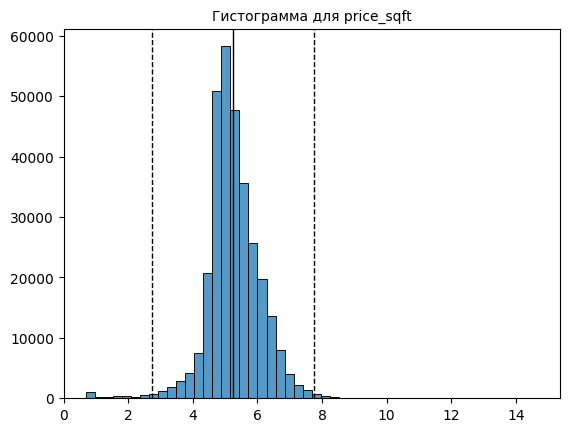

In [123]:
# Задаем границы отклонений в сигмах и признак
left = 3
right = 3
feat = 'price_sqft'
# Добавляем одноименный признак с флагом отклонений
df['outliers_price_sqft'] = 0

# Определяем выборосы с помощью написанной функции
outliers, cleaned = outliers_z_score(df=df, feature=feat,
                                     log_scale=True,
                                     left=left, right=right)

# Выводим результат работы на экран и устанавливаем флаги в признаке
print(f'Число выбросов по методу z-отклонений для {feat}: {outliers.shape[0]}')
print(f'Результирующее число записей для {feat}: {cleaned.shape[0]}')
df.loc[outliers.index, 'outliers_price_sqft'] = 1

# Отрисуем гистограмму
bar_chart(df, feat, left, right)

Число выбросов по методу z-отклонений для sqft: 2568
Результирующее число записей для sqft: 320540


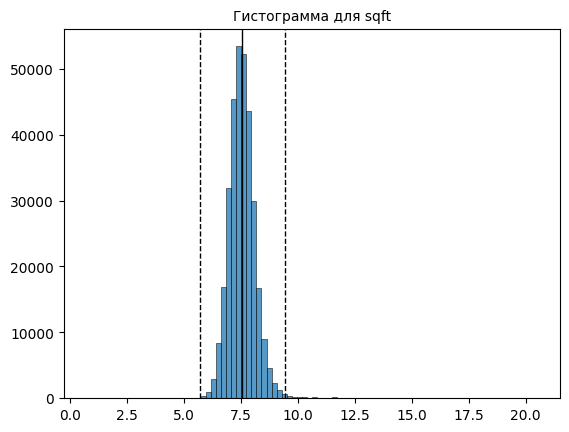

In [124]:
# Задаем границы отклонений в сигмах и признак
left = 3
right = 3
feat = 'sqft'
# Добавляем одноименный признак с флагом отклонений
df['outliers_sqft'] = 0

# Определяем выборосы с помощью написанной функции
outliers, cleaned = outliers_z_score(df=df, feature=feat,
                                     log_scale=True,
                                     left=left, right=right)

# Выводим результат работы на экран и устанавливаем флаги в признаке
print(f'Число выбросов по методу z-отклонений для {feat}: {outliers.shape[0]}')
print(f'Результирующее число записей для {feat}: {cleaned.shape[0]}')
df.loc[outliers.index, 'outliers_sqft'] = 1

# Отрисуем гистограмму
bar_chart(df, feat, left, right, bins=90)

In [125]:
# Вычисляем сумму флагов выбросов по всем признакам и сохраняем в столбец 'total_outliers'
df['total_outliers'] = df[['outliers', 'outliers_sqft', 'outliers_price_sqft']].sum(axis=1)

# Выводим количество записей с выбросами
total_outliers_count = df[df['total_outliers'] > 0].shape[0]
print('Всего к выбросам отнесено записей:', total_outliers_count)

Всего к выбросам отнесено записей: 11558


In [126]:
# Формируем список индексов для удаления: выбросы и неадекватная площадь
outliers_indices = set(df[df['total_outliers'] > 0].index)
sqft_over_target_indices = set(df[df['sqft'] >= df['target']].index)
indices_to_drop = outliers_indices.union(sqft_over_target_indices)

# Удаляем записи с выбросами и некорректной площадью
df.drop(indices_to_drop, axis=0, inplace=True)

# Удаляем ненужные признаки
columns_to_drop = ['outliers', 'outliers_sqft', 'outliers_price_sqft',
                   'total_outliers']
df.drop(columns_to_drop, axis=1, inplace=True)

# Удаляем записи с оставшимися пропусками
df.dropna(subset=['sqft'], axis=0, inplace=True)

In [127]:
# удаляем признак price_sqft 
df.drop('price_sqft', axis=1, inplace=True)

В заключении посмотрим на диаграмму рассеивания и коробчатую диаграмму для признака "sqft".

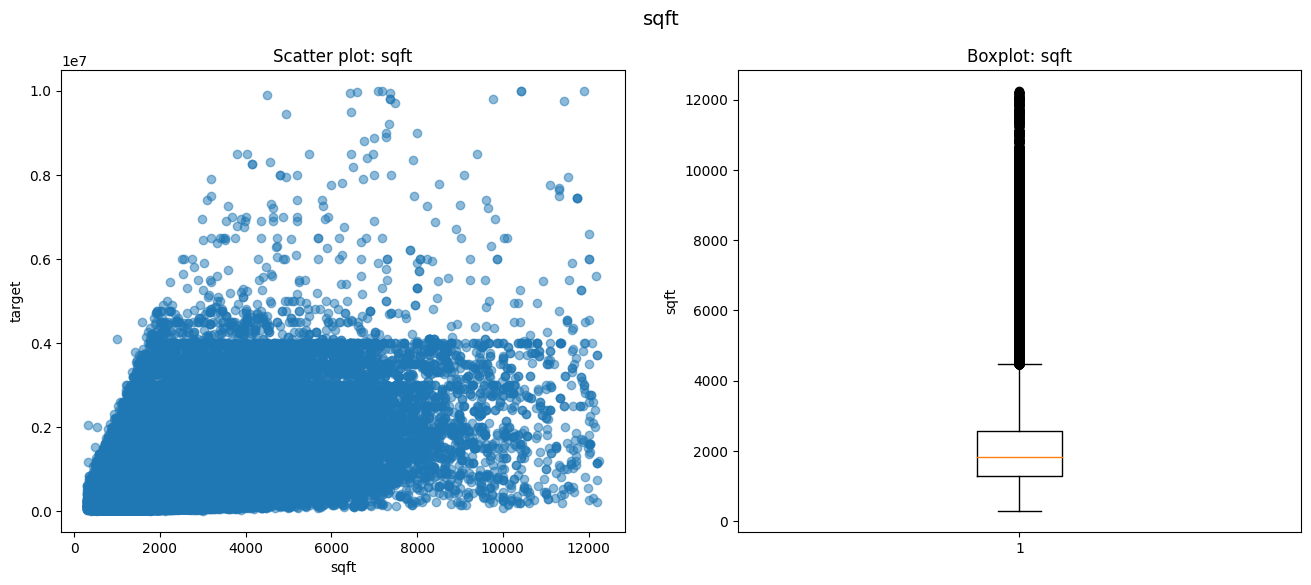

In [451]:
# Создание графиков рассеивания и ящиков с усами для столбца 'sqft'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'sqft', fontsize=14)

# График рассеивания
ax1.scatter(df['sqft'], df['target'], alpha=0.5)
ax1.set_title(f'Scatter plot: sqft')
ax1.set_xlabel('sqft')
ax1.set_ylabel('target')

# Ящик с усами
ax2.boxplot(df['sqft'])
ax2.set_title(f'Boxplot: sqft')
ax2.set_ylabel('sqft')

plt.show()

In [133]:
# Проверим количество объектов, у которых площадь больше 10000 кв. футов
sqft_too_much = df[df['sqft'] > 10000].index
print(f'Площадь больше 10000 кв. футов насчитывается в {len(sqft_too_much)} объектах')
print('Это составляет {:2.2%} всего датафрейма'.format(len(sqft_too_much)/df.shape[0]))

# Удаляем эти записи и очищаем память
df.drop(sqft_too_much, axis=0, inplace=True)
del sqft_too_much

Площадь больше 10000 кв. футов насчитывается в 354 объектах
Это составляет 0.11% всего датафрейма


Ещё раз проведём дополнительную проверку:

In [134]:
df.head()

,status,propertyType,baths,city,sqft,zipcode,beds,state,target,private_pool,new_fireplace,age,heating_bin,cooling_bin,parking_bin,school_rating,school_distance
0,Active,single_family_home,3.5,southern pines,2900.0,28387,4.0,NC,418000,0,0,4,1,0,0,5.2,2.70
1,For Sale,single_family_home,2.5,spokane valley,1947.0,99216,3.0,WA,310000,0,0,4,0,0,0,4.0,1.01
2,For Sale,single_family_home,2.5,los angeles,3000.0,90049,3.0,CA,2895000,1,1,56,1,1,1,6.7,1.19
3,For Sale,single_family_home,2.5,dallas,6457.0,75205,5.0,TX,2395000,0,1,17,1,1,1,5.6,0.10
5,For Sale,townhouse,3.0,philadelphia,897.0,19145,2.0,PA,209000,0,0,103,1,1,0,0.0,-1.00


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311704 entries, 0 to 377184
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   status           311704 non-null  object 
 1   propertyType     311704 non-null  object 
 2   baths            311704 non-null  float64
 3   city             311704 non-null  object 
 4   sqft             311704 non-null  float64
 5   zipcode          311704 non-null  object 
 6   beds             311704 non-null  float64
 7   state            311704 non-null  object 
 8   target           311704 non-null  int64  
 9   private_pool     311704 non-null  int64  
 10  new_fireplace    311704 non-null  int64  
 11  age              311704 non-null  int64  
 12  heating_bin      311704 non-null  int64  
 13  cooling_bin      311704 non-null  int64  
 14  parking_bin      311704 non-null  int64  
 15  school_rating    311704 non-null  float64
 16  school_distance  311704 non-null  floa

## Отбор значимых признаков

In [455]:
# Составим список бинарных признаков:
binary_features = ['private_pool','new_fireplace','heating_bin','cooling_bin','parking_bin']

# Составим список категориальных признаков:
categorical_features = ['status','city','zipcode','state','propertyType']
 
# Составим список числовых признаков:
numeric_features = ['baths', 'sqft', 'target', 'beds', 'age', 'school_rating', 'school_distance']

## Оценка мультиколлинеарности признаков

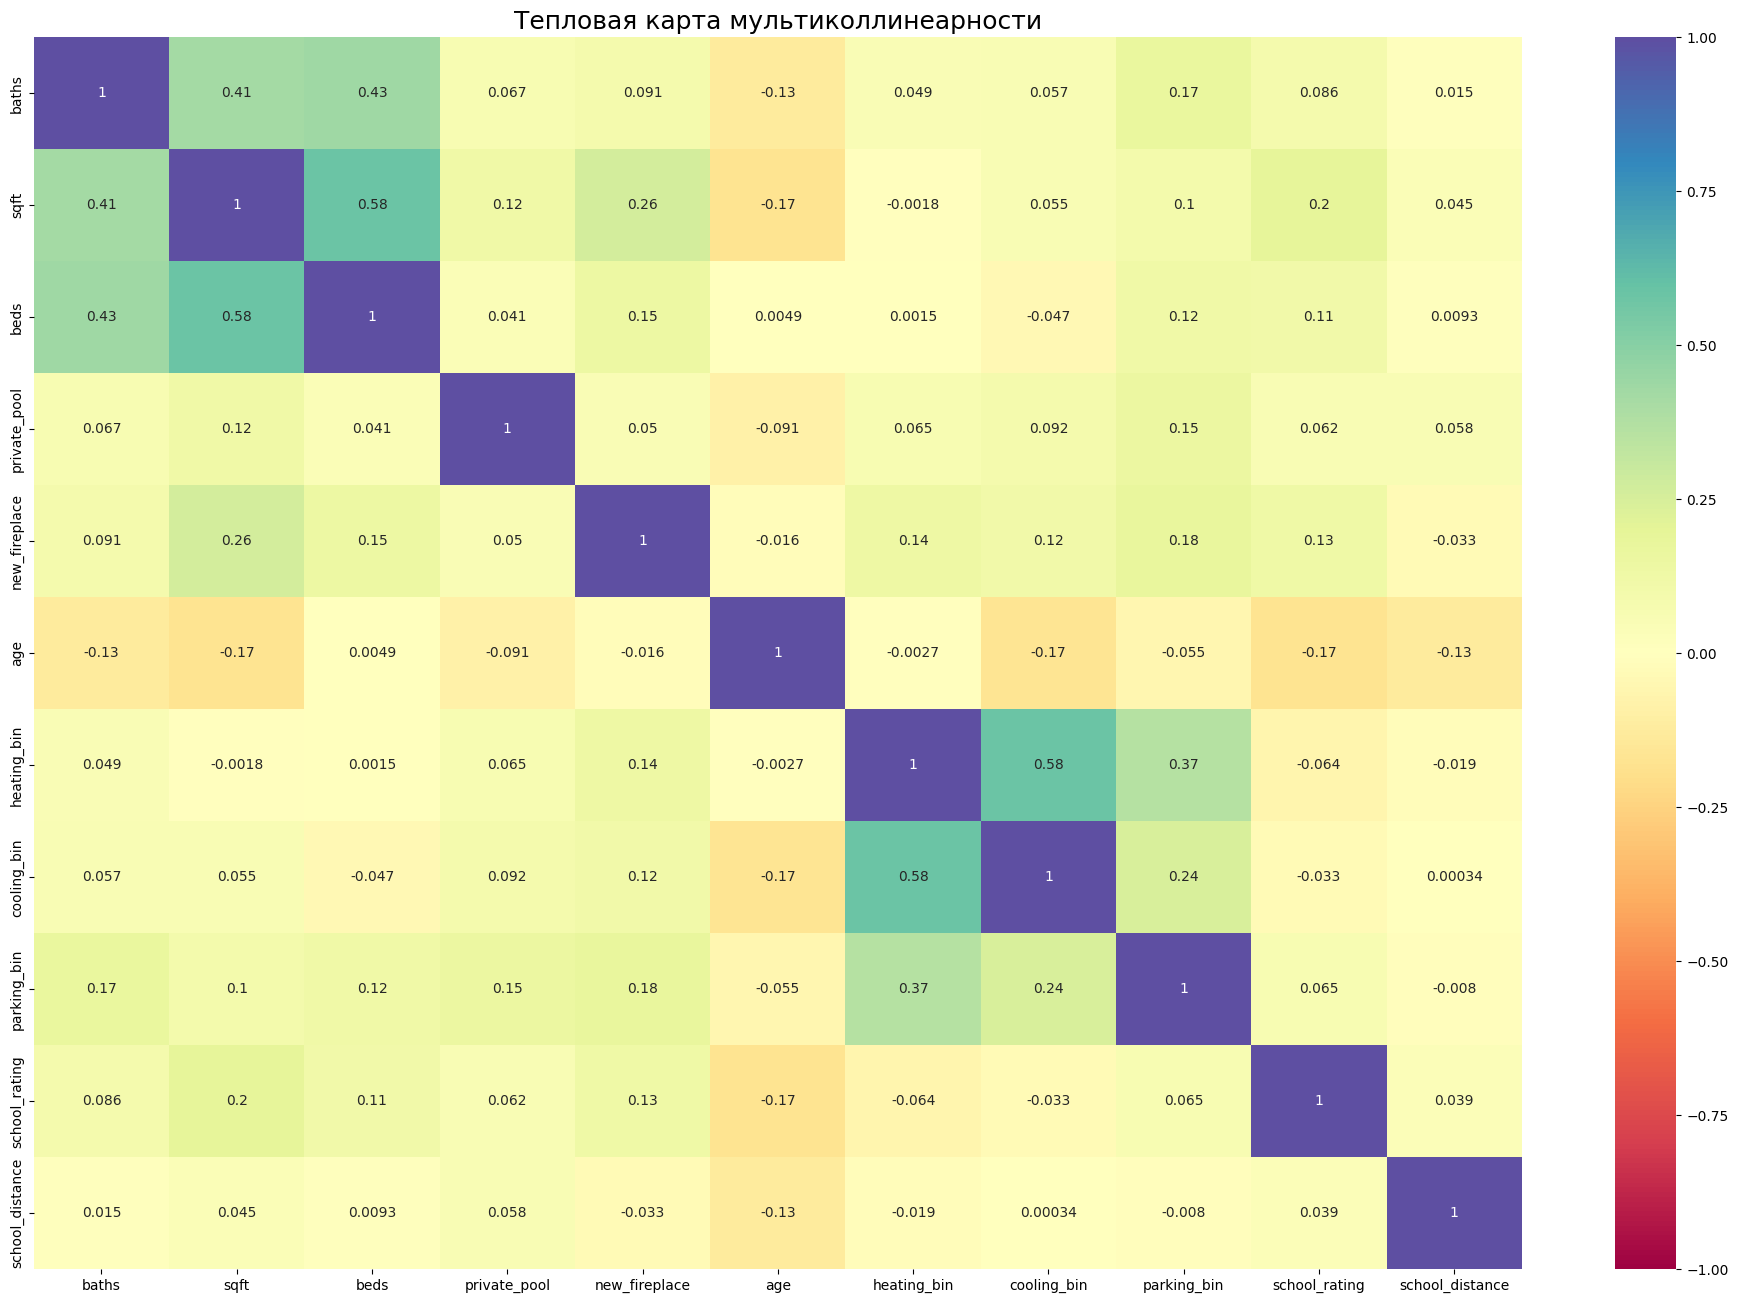

In [456]:
# Построим тепловую карту мультиколлинеарности
plt.figure(figsize=(24, 16))
heatmap = sns.heatmap(
    df.drop('target', axis=1).corr(method='pearson'),
    annot=True,
    fmt='.2g',
    vmin=-1,
    vmax=1,
    center=0,
    cmap='Spectral'
)
heatmap.set_title('Тепловая карта мультиколлинеарности', fontsize=18)
plt.show()

Мультиколлинеарность признаков отсутствует, существует средняя связь между наличием отопления и системы охлаждения, площадью и количеством спален и ванных, а также между количеством ванных и спален между собой, что логично.

## Тест ANOVA для непрерывных признаков

<AxesSubplot: >

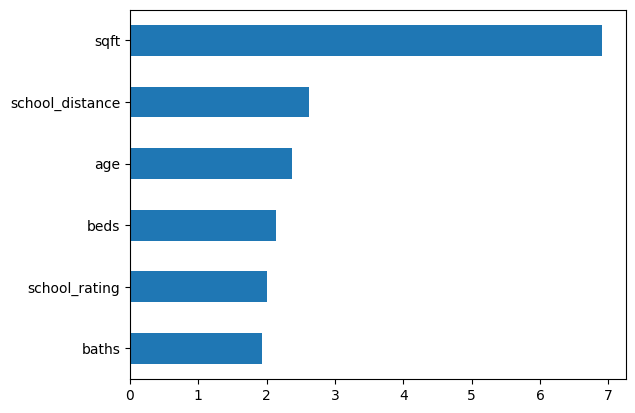

In [457]:
# Посмотрим на значимость непрерывных признаков
continuous = list(set(numeric_features).difference(categorical_features))
continuous_test = continuous.copy()
continuous_test.remove('target')
imp_num = pd.Series(f_classif(df[continuous_test], df.target)[0], index = continuous_test)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Можем сделать вывод, что все непрерывные признаки значимы.

## хи-квадрат (chi-squared) для бинарных признаков

In [458]:
# Создаём таблицу сопряженности для каждого бинарного признака по отдельности
contingency_private_pool = pd.crosstab(df['private_pool'], df['target'])
contingency_new_fireplace = pd.crosstab(df['new_fireplace'], df['target'])
contingency_heating_bin = pd.crosstab(df['heating_bin'], df['target'])
contingency_cooling_bin = pd.crosstab(df['cooling_bin'], df['target'])
contingency_parking_bin = pd.crosstab(df['parking_bin'], df['target'])

# Вычисляем статистику хи-квадрат и p-значение для каждой таблицы сопряженности
chi2_private_pool, p_private_pool, _, _ = stats.chi2_contingency(contingency_private_pool)
chi2_new_fireplace, p_new_fireplace, _, _ = stats.chi2_contingency(contingency_new_fireplace)
chi2_heating_bin, p_heating_bin, _, _ = stats.chi2_contingency(contingency_heating_bin)
chi2_cooling_bin, p_cooling_bin, _, _ = stats.chi2_contingency(contingency_cooling_bin)
chi2_parking_bin, p_parking_bin, _, _ = stats.chi2_contingency(contingency_parking_bin)

# Оцениваем значимость для каждого бинарного признака
if p_private_pool < 0.05:
    print("private_pool значим.")
else:
    print("private_pool не значим.")
    
if p_new_fireplace < 0.05:
    print("new_fireplace значим.")
else:
    print("new_fireplace не значим.")
    
if p_heating_bin < 0.05:
    print("heating_bin значим.")
else:
    print("heating_bin не значим.")
    
if p_cooling_bin < 0.05:
    print("cooling_bin значим.")
else:
    print("cooling_bin не значим.")
    
if p_parking_bin < 0.05:
    print("parking_bin значим.")
else:
    print("parking_bin не значим.")

private_pool значим.
new_fireplace значим.
heating_bin значим.
cooling_bin значим.
parking_bin значим.


Все бинарные переменные также значимы.

## Анализ дисперсии (ANOVA) для категориальных признаков. 

In [459]:
# Разбиваем данные на группы по категориальному признаку
categories = ['status', 'city', 'zipcode', 'state', 'propertyType']

for category in categories:
    groups = [df[df[category] == unique_category]['target'] for unique_category in df[category].unique()]

    # Выполняем однофакторный дисперсионный анализ (ANOVA) для каждой категории
    F, p = stats.f_oneway(*groups)

    # Оцениваем значимость для каждой категории
    if p < 0.05:  # Пороговое значение для уровня значимости (обычно 0.05)
        print(f"Категориальный признак '{category}' значим.")
    else:
        print(f"Категориальный признак '{category}' не значим.")

Категориальный признак 'status' значим.
Категориальный признак 'city' значим.
Категориальный признак 'zipcode' значим.
Категориальный признак 'state' значим.
Категориальный признак 'propertyType' значим.


Видим также, что все категориальные признаки значимы.

## Кодирование признаков

In [136]:
# Отобразим количество уникальных значений для выбора метода кодировки
display('Количество уникальных значений в категориальных признаках:',
        df.select_dtypes(include='object').nunique())

'Количество уникальных значений в категориальных признаках:'

status             7
propertyType       8
city            1710
zipcode         4168
state             34
dtype: int64

Выполним кодирование категориальных признаков в нашем датафрейме, используя одиночное кодирование (One-Hot Encoding) для status и propertyType, и бинарное кодирование (Binary Encoding) для city, zipcode, и state.

In [137]:
# Создаем список признаков для одиночного кодирования (One-Hot Encoding)
oh_cols = ['status', 'propertyType']

# Создаем объект одиночного кодирования и выполняем кодирование
encoder = ce.OneHotEncoder(cols=oh_cols, use_cat_names=True)
encoded_data = encoder.fit_transform(df[oh_cols])

# Присоединяем закодированные признаки к датафрейму
df = pd.concat([df, encoded_data], axis=1)

# Создаем объект бинарного кодирования (Binary Encoding) и выполняем кодирование
encoder = ce.BinaryEncoder(cols=['city', 'zipcode', 'state'])
encoded_data = encoder.fit_transform(df[['city', 'zipcode', 'state']])

# Присоединяем закодированные признаки к датафрейму
df = pd.concat([df, encoded_data], axis=1)

# Удаляем исходные категориальные признаки после кодирования
df = df.drop(['status', 'propertyType', 'city', 'zipcode', 'state'], axis=1)

# Выводим размер получившегося датафрейма
print('Размер получившегося датафрейма:', df.shape)

Размер получившегося датафрейма: (311704, 57)


In [463]:
df.head()

,baths,sqft,beds,target,private_pool,new_fireplace,age,heating_bin,cooling_bin,parking_bin,...,zipcode_9,zipcode_10,zipcode_11,zipcode_12,state_0,state_1,state_2,state_3,state_4,state_5
0,3.5,2900.0,4.0,418000,0,0,4,1,0,0,...,0,0,0,1,0,0,0,0,0,1
1,2.5,1947.0,3.0,310000,0,0,4,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,2.5,3000.0,3.0,2895000,1,1,56,1,1,1,...,0,0,1,1,0,0,0,0,1,1
3,2.5,6457.0,5.0,2395000,0,1,17,1,1,1,...,0,1,0,0,0,0,0,1,0,0
5,3.0,897.0,2.0,209000,0,0,103,1,1,0,...,0,1,0,1,0,0,0,1,0,1


## Разделение датафрейма на тренировочную и тестовую выборки

In [138]:
# Разделяем датафрейм и готовим выборки
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

# Проверим размерности
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(218192, 56) (93512, 56) (218192,) (93512,)


## Нормализация и стандартизация признаков

Результаты исследований свидетельствовали о том, что нормализация и стандартизация данных не приводят к улучшению метрик, а, наоборот, немного снижают её эффективность. По этой причине этот этап мы пропустим.

## Моделирование (решение задачи регрессии)

В этом этапе мы применим различные методы машинного обучения для выполнения прогнозирования стоимости недвижимости. Мы будем обучать модели, начиная с простых и постепенно переходя к более сложным:
- Линейная регрессия (Baseline)
- Модель DecisionTreeRegressor.
- Модель RandomForestRegressor.
- Модель GradientBoostingRegressor.
- Модель StackingRegressor.
- Модель CatBoostRegressor.

Мы также попробуем настроить гиперпараметры с помощью методов RandomizedSearchCV и Optuna.
В заключении мы сделаем сводную таблицу и сравним полученные результаты.

Для начала добавим функцию для более наглядного вывода метрик. В качестве метрик будем использовать MAE, MAPE и R2.

In [142]:
# Функция для расчета метрик и вывода на экран
def reveal_metrics(y_train: pd.Series,
                 y_train_pred: pd.Series,
                 y_test: pd.Series,
                 y_test_pred: pd.Series,
                 precision: int = 2,
                 show: bool = True) -> tuple:
    
    # Вычислим метрики и выведем их на экран
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)*100
    r2_train = r2_score(y_train, y_train_pred)

    mae_test = mean_absolute_error(y_test, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred)*100
    r2_test = r2_score(y_test, y_test_pred)

    if show: # если флаг вывода на экран установлен
        print('MAE на тренировочоной выборке:', round(mae_train, precision))
        print('MAPE на тренировочной выборке:', round(mape_train, precision))
        print('r2 на тренировочоной выборке:', round(r2_train,2))

        print('\nMAE на тестовой выборке:', round(mae_test, precision))
        print('MAPE на тестовой выборке:', round(mape_test, precision))
        print('r2 на тестовой выборке:', round(r2_test,2))

    # Вернем вычисленные метрики
    return mae_train, mape_train, r2_train, mae_test, mape_test, r2_test

## Линейная регрессия (Baseline)

In [466]:
# Обучим модель линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Выполним предсказание и выведем результат
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Выведем значеня метрик с помощью написанной функции
_ = reveal_metrics(y_train, y_train_pred, y_test, y_test_pred)

MAE на тренировочоной выборке: 249121.26
MAPE на тренировочной выборке: 75.53
r2 на тренировочоной выборке: 0.44

MAE на тестовой выборке: 248589.98
MAPE на тестовой выборке: 75.88
r2 на тестовой выборке: 0.44


Значение MAE (Mean Absolute Error) на тестовой выборке равно 248,6 тыс.$. Значение MAPE (Mean Absolute Percentage Error) на тестовой выборке равно 75.9. Значение R2 (коэффициент детерминации) на тестовой выборке равен 0.44. Текущее качество модели не удовлетворительно.

Я думаю причина такого качества в простоте модели. Линейная регрессия - это очень простая модель, которая предполагает линейную зависимость между признаками и целевой переменной. Если зависимость в данных сложнее, то линейная модель может недооценить эту сложность и давать низкие метрики.

Итак наша цель минимизировать значения метрик MAE и MAPE и приблизить значение коэффициента детерминации к 1. Для достижения этой цели мы рассмотрим альтернативные методы машинного обучения.

Сделаю сразу ремарку, обучить модель на полиномиальных признаках не удалось. Из - за большого объема данных ядро аварийно завершает работу.

## DecisionTreeRegressor

Сначала воспользуемся DecisionTreeRegressor - моделью регрессии на основе дерева решений. 

Исследуем, как глубина дерева влияет на качество модели решающего дерева, а также визуализировать зависимость метрик от глубины дерева для обучающей и тестовой выборок.

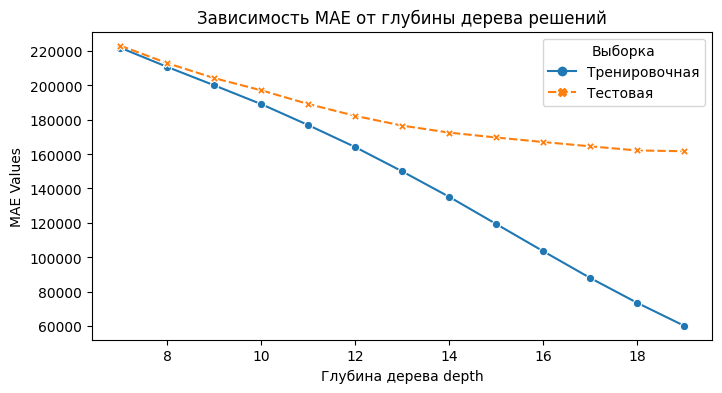

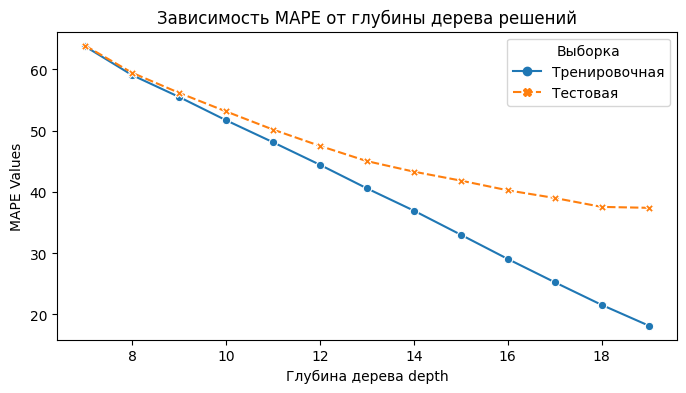

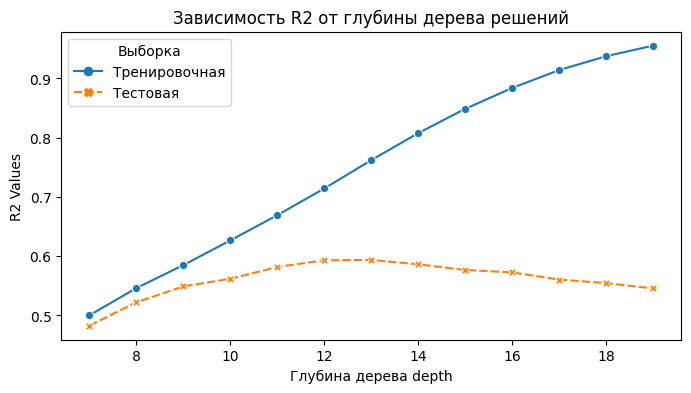

In [467]:
# Подготовим списки с глубиной дерева и для значений метрики
depths = list(np.arange(7, 20))
mae_train_score = []
mae_test_score = []
mape_train_score = []
mape_test_score = []
r2_train_score = []
r2_test_score = []

# Обучим модель с каждым значением глубины дерева и сохраним результаты
for depth in depths:
    # Создаём модель дерева решений
    tree_regressor = DecisionTreeRegressor(
        max_depth = depth,
        random_state = 42)

    # Обучаем модель
    tree_regressor.fit(X_train, y_train)

    # Получаем прогнозы
    y_train_pred = tree_regressor.predict(X_train)
    y_test_pred = tree_regressor.predict(X_test)

    # Вычисляем метрики качества
    mae_train, mape_train, r2_train, mae_test, mape_test, r2_test\
        = reveal_metrics(y_train, y_train_pred, y_test, y_test_pred, show = False)

    # Добавим значения метрик в списки
    mae_train_score.append(mae_train)
    mae_test_score.append(mae_test)
    mape_train_score.append(mape_train)
    mape_test_score.append(mape_test)
    r2_train_score.append(r2_train)
    r2_test_score.append(r2_test)


# Преобразуем списки в датафреймы
mae_df = pd.DataFrame(
    data = {'Тренировочная': mae_train_score,
            'Тестовая': mae_test_score},
    index = depths)

mape_df = pd.DataFrame(
    data = {'Тренировочная': mape_train_score,
            'Тестовая': mape_test_score},
    index = depths)

r2_df = pd.DataFrame(
    data = {'Тренировочная': r2_train_score,
            'Тестовая': r2_test_score},
    index = depths)

# Построим графики зависимости MAE
fig = plt.figure(figsize=(8, 4))
lineplot = sns.lineplot(
    data = mae_df,
    dashes = True,
    markers = True
);
lineplot.set_title('Зависимость MAE от глубины дерева решений');
lineplot.set_ylabel('MAE Values');
lineplot.set_xlabel('Глубина дерева depth');
lineplot.legend(title ='Выборка');

# Построим линейный график зависимости MAPE
fig = plt.figure(figsize=(8, 4))
lineplot = sns.lineplot(
    data = mape_df,
    dashes = True,
    markers = True
);
lineplot.set_title('Зависимость MAPE от глубины дерева решений');
lineplot.set_ylabel('MAPE Values');
lineplot.set_xlabel('Глубина дерева depth');
lineplot.legend(title ='Выборка');

# Построим линейный график зависимости R2
fig = plt.figure(figsize=(8, 4))
lineplot = sns.lineplot(
    data = r2_df,
    dashes = True,
    markers = True
);
lineplot.set_title('Зависимость R2 от глубины дерева решений');
lineplot.set_ylabel('R2 Values');
lineplot.set_xlabel('Глубина дерева depth');
lineplot.legend(title ='Выборка');

Судя по графику MAE и MAPE, мы можем утверждать, что оптимальной глубиной является 16, поскольку после этой точки значение метрики на тестовой выборке начинает возрастать, в то время как значение метрики на тренировочной выборке продолжает снижаться. Это намекает на избыточное обучение модели.

In [471]:
# посмотрим метрики при оптимальной глубине
opt_depth=16
print('MAE:', mae_test_score[depths.index(opt_depth)])
print('MAPE:', mape_test_score[depths.index(opt_depth)])
print('R2:', r2_test_score[depths.index(opt_depth)])

MAE: 167046.59640818718
MAPE: 40.25563553896652
R2: 0.572297053156491


Обучим дерево с максимальной глубиной 16 и минимальным количеством листьев 10 и посмотрим как изменятся метрики.

In [472]:
# Строим и обучаем модель дерева решений
tree_regressor = DecisionTreeRegressor(
    max_depth = 16,
    min_samples_leaf = 10,
    random_state = 42)

# Обучаем модель
%time tree_regressor.fit(X_train, y_train)

# Выполняем предсказание
y_train_pred = tree_regressor.predict(X_train)
y_test_pred = tree_regressor.predict(X_test)

# Вычисляем метрики качества
_ = reveal_metrics(y_train, y_train_pred, y_test, y_test_pred)

CPU times: user 7.58 s, sys: 295 ms, total: 7.88 s
Wall time: 7.94 s
MAE на тренировочоной выборке: 136963.93
MAPE на тренировочной выборке: 34.05
r2 на тренировочоной выборке: 0.77

MAE на тестовой выборке: 164606.66
MAPE на тестовой выборке: 40.27
r2 на тестовой выборке: 0.64


Нам значительно удалось улучшить качество метрик по сравнению с baseline решением, перейдём к другим алгоритмам машинного обучения.

## RandomForestRegressor

Обучим модель случайного леса, воспользовавшись автоматическим подбором гиперпараметров RandomizedSearchCV.

In [473]:
# Создаем сетку перебираемых параметров
param_distributions = {
    'n_estimators': [100, 150, 200],
    'max_depth': np.arange(11, 18, 2),
    'min_samples_leaf': [5, 10, 15]
}

# Создаем модель RandomizedSearchCV
random_forest = RandomizedSearchCV(
    estimator = RandomForestRegressor(
        n_jobs = -1,
        warm_start = True,
        random_state = 42),
    param_distributions = param_distributions,
    cv = 2,
    scoring = 'r2',
    return_train_score = False,
    n_jobs = -1,
    verbose = 1
)

# Обучим модель
%time random_forest.fit(X_train, y_train)

# Сделаем предсказания
y_train_pred = random_forest.predict(X_train)
y_test_pred = random_forest.predict(X_test)

# Вычисляем метрики качества
_ = reveal_metrics(y_train, y_train_pred, y_test, y_test_pred)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


CPU times: user 20min 58s, sys: 9.56 s, total: 21min 8s
Wall time: 50min 27s
MAE на тренировочоной выборке: 122433.92
MAPE на тренировочной выборке: 32.88
r2 на тренировочоной выборке: 0.83

MAE на тестовой выборке: 145679.81
MAPE на тестовой выборке: 38.02
r2 на тестовой выборке: 0.73


In [474]:
# Выведем подобранные значения гиперпараметров, использованные для прогноза
print('Наилучшие значения гиперпараметров:', random_forest.best_params_)

Наилучшие значения гиперпараметров: {'n_estimators': 200, 'min_samples_leaf': 5, 'max_depth': 15}


Более сложная модель приводит к улучшению результатов, в том числе благодаря алгоритму оптимизации гиперпараметров, но стоит заметить, что существенно возрасло время обучения модели.

## GradientBoostingRegressor

Отметим, что градиентный бустинг оперирует относительно недолгими моделями, которые последовательно стараются улучшить точность предсказаний, учитывая ошибки предыдущих шагов. Градиентный бустинг в качестве базовой модели использует деревья решений.

Ранее мы выявили, что деревья решений показывают более скромные результаты в сравнении с случайным лесом. Посмотрим, какие улучшения мы сможем достичь с помощью градиентного бустинга.

In [475]:
# Строим модель градиентного бустинга
boosting_regressor = GradientBoostingRegressor(
    learning_rate = 0.1,
    n_estimators = 100,
    max_depth = 15,
    min_samples_split = 20,
    random_state = 42
)

# Обучаем модель
%time boosting_regressor.fit(X_train, y_train)

# Выполняем предсказание
y_train_pred = boosting_regressor.predict(X_train)
y_test_pred = boosting_regressor.predict(X_test)

# Вычисляем метрики качества
_ = reveal_metrics(y_train, y_train_pred, y_test, y_test_pred)

CPU times: user 13min 56s, sys: 394 ms, total: 13min 57s
Wall time: 13min 59s
MAE на тренировочоной выборке: 49108.36
MAPE на тренировочной выборке: 13.92
r2 на тренировочоной выборке: 0.98

MAE на тестовой выборке: 116759.79
MAPE на тестовой выборке: 28.17
r2 на тестовой выборке: 0.79


Использование градиентного бустинга привело к более выдающимся результатам, но существует опасность переобучения модели, так как она продемонстрировала очень высокие результаты (R2=0.98) на тренировочной выборке и более низкие на тестовой.

Попробуем снизить переобучение, для этого применим L-2 регуляризацию, а также уменьшим глубину дерева и минимальное количество образцов (примеров) данных, которое необходимо для разделения узла (вершины) дерева.

In [476]:
# Строим модель градиентного бустинга
boosting_regressor = GradientBoostingRegressor(
    learning_rate = 0.1,
    n_estimators = 100,
    max_depth = 10,
    min_samples_split = 5,
    alpha=0.1,  # Параметр L2-регуляризации
    random_state = 42
)

# Обучаем модель
%time boosting_regressor.fit(X_train, y_train)

# Выполняем предсказание
y_train_pred = boosting_regressor.predict(X_train)
y_test_pred = boosting_regressor.predict(X_test)

# Вычисляем метрики качества
_ = reveal_metrics(y_train, y_train_pred, y_test, y_test_pred)

CPU times: user 9min 38s, sys: 527 ms, total: 9min 39s
Wall time: 9min 41s
MAE на тренировочоной выборке: 105029.24
MAPE на тренировочной выборке: 27.92
r2 на тренировочоной выборке: 0.89

MAE на тестовой выборке: 133408.15
MAPE на тестовой выборке: 33.5
r2 на тестовой выборке: 0.77


Видим, что при помощи регуляризации, а также уменьшения глубины и минимального количества листьев нам удалось снизить переобучение модели, правда при этом несколько снизились метрики. 

##  Stacking

Стекинг (stacking) - это метод ансамблирования в машинном обучении, который объединяет прогнозы нескольких базовых моделей (слабых учеников) с целью улучшения предсказательной способности. Используем наши нескольких моделей: деревья решений, случайные лес и градиентный бустинг.

In [477]:
# Создаем список моделей для стекинга с подобранными ранее параметрами
estimators = [
    ('dt', DecisionTreeRegressor(
        max_depth = 16,
        min_samples_leaf = 10,
        random_state = 42)
    ),
    ('rf', RandomForestRegressor(
        n_estimators = 200,
        max_depth = 15,
        min_samples_leaf = 5,
        n_jobs = -1,
        warm_start = True,
        random_state = 42)
    ),
    ('gb', GradientBoostingRegressor(
        learning_rate = 0.1,
        n_estimators = 100,
        max_depth = 15,
        min_samples_split = 20,
        random_state = 42)
    )
]

# Создаем объект класса стекинг
stacking_regressor = StackingRegressor(
    estimators = estimators,
    final_estimator = RandomForestRegressor(
        n_estimators = 150,
        max_depth = 17,
        min_samples_leaf = 5,
        n_jobs = -1,
        warm_start = True,
        random_state = 42),
    cv = 2,
    n_jobs = -1,
    verbose = 5
)

# Обучаем модель
%time stacking_regressor.fit(X_train, y_train)

# Делаем предсказание
y_train_pred = stacking_regressor.predict(X_train)
y_test_pred = stacking_regressor.predict(X_test)

# Вычисляем метрики качества
_ = reveal_metrics(y_train, y_train_pred, y_test, y_test_pred)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 10.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 10.2min finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 12.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 12.4min finished


CPU times: user 5min 40s, sys: 3.38 s, total: 5min 43s
Wall time: 33min 4s
MAE на тренировочоной выборке: 57683.53
MAPE на тренировочной выборке: 15.05
r2 на тренировочоной выборке: 0.96

MAE на тестовой выборке: 118090.72
MAPE на тестовой выборке: 27.81
r2 на тестовой выборке: 0.79


Качество метрик схоже с моделью градиентного бустинга, но также есть признаки переобучения модели. Попробуем увеличить количество фолдов для уменьшения переобучения:

In [478]:
# Создаем список моделей для стекинга с подобранными ранее параметрами
estimators = [
    ('dt', DecisionTreeRegressor(
        max_depth=16,
        min_samples_leaf=10,
        random_state=42)
    ),
    ('rf', RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_leaf=5,
        n_jobs=-1,
        warm_start=True,
        random_state=42)
    ),
    ('gb', GradientBoostingRegressor(
        learning_rate=0.1,
        n_estimators=100,
        max_depth=15,
        min_samples_split=20,
        random_state=42)
    )
]

# Создаем объект класса стекинг
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(
        n_estimators=150,
        max_depth=17,
        min_samples_leaf=5,
        n_jobs=-1,
        warm_start=True,
        random_state=42),
    cv=5,  # Увеличим количество фолдов
    n_jobs=-1,
    verbose=5
)

# Обучаем модель
%time stacking_regressor.fit(X_train, y_train)

# Делаем предсказание
y_train_pred = stacking_regressor.predict(X_train)
y_test_pred = stacking_regressor.predict(X_test)

# Вычисляем метрики качества
_ = reveal_metrics(y_train, y_train_pred, y_test, y_test_pred)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   21.9s remaining:   32.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.3s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 38.0min remaining: 57.0min
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 43.1min remaining: 64.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 52.7min finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 57.8min finished


CPU times: user 5min 36s, sys: 4.56 s, total: 5min 41s
Wall time: 1h 18min 20s
MAE на тренировочоной выборке: 54865.27
MAPE на тренировочной выборке: 14.56
r2 на тренировочоной выборке: 0.97

MAE на тестовой выборке: 117398.44
MAPE на тестовой выборке: 27.66
r2 на тестовой выборке: 0.79


Можем наблюдать некоторое улучшение качества метрик, но проблема переобучения осталась. Возможно причина в использовании слишком сложных базовых моделей, либо в недостаточном разнообразии базовых моделей. 

##  CatBoostRegressor и Optuna

CatBoostRegressor - это библиотека машинного обучения, предназначенная для задачи регрессии. Она основана на алгоритме градиентного бустинга и спроектирована для эффективной работы с категориальными признаками без необходимости их предварительного кодирования. 

Основные особенности CatBoostRegressor включают в себя автоматическую обработку категориальных признаков, реализацию градиентного бустинга с применением встроенной регуляризации, поддержку распределенных вычислений и обучения на GPU, а также ряд других оптимизаций для улучшения производительности и качества предсказаний.

В нашем коде, CatBoostRegressor используется для построения модели регрессии, а Optuna - для автоматической настройки гиперпараметров этой модели, с целью достижения наилучшей производительности.

In [139]:
# Создадим функцию расчета целевой метрики
def optuna_rf(trial,
              cv: int = 3,
              X: pd.DataFrame = X_train,
              y: pd.Series = y_train) -> float:
    # Задаем пространство поиска гиперпараметров
    iterations = trial.suggest_int('iterations', 20, 50, 10)
    depth = trial.suggest_int('depth', 11, 15, 2)
    learning_rate = trial.suggest_float('learning_rate', 0.3, 1.0, step=0.1)

    # Cоздаем модель CatBoostRegressor
    model = CatBoostRegressor(
        iterations = iterations,
        depth = depth,
        learning_rate = learning_rate,
        loss_function = 'RMSE',
        random_state = 42,
        thread_count = -1,
        boosting_type = 'Plain',
        verbose = False
    )

    # Готовим выборки для подачи в модель в виде класса Pool
    train_pool = Pool(X, y)

    # Обучаем модель с помощью кросс-валидации
    model.fit(train_pool)
    score = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1).mean()

    # Возвращаем значение метрики
    return score

# Создаем объект исследования study для подбора гиперпараметров
study = optuna.create_study(study_name='CatBoostRegressor', direction='maximize')

# Выполняем оптимизацию гиперпараметров 10 раз
%time study.optimize(optuna_rf, n_trials=10)

[I 2023-10-12 14:54:43,056] A new study created in memory with name: CatBoostRegressor
[I 2023-10-12 14:56:54,417] Trial 0 finished with value: 0.7467852261200357 and parameters: {'iterations': 20, 'depth': 15, 'learning_rate': 0.5}. Best is trial 0 with value: 0.7467852261200357.
[I 2023-10-12 14:58:02,228] Trial 1 finished with value: 0.7670478084300992 and parameters: {'iterations': 40, 'depth': 13, 'learning_rate': 0.5}. Best is trial 1 with value: 0.7670478084300992.
[I 2023-10-12 14:59:20,604] Trial 2 finished with value: 0.7799950841372575 and parameters: {'iterations': 50, 'depth': 13, 'learning_rate': 0.4}. Best is trial 2 with value: 0.7799950841372575.
[I 2023-10-12 15:03:18,782] Trial 3 finished with value: 0.7599856566656512 and parameters: {'iterations': 50, 'depth': 15, 'learning_rate': 0.7}. Best is trial 2 with value: 0.7799950841372575.
[I 2023-10-12 15:05:37,150] Trial 4 finished with value: 0.7640495040940959 and parameters: {'iterations': 30, 'depth': 15, 'learning

CPU times: user 8min 50s, sys: 1min 53s, total: 10min 43s
Wall time: 13min 34s


In [140]:
# Выводим результаты на обучающей выборке
print('Наилучшие значения гиперпараметров:', study.best_params)
print('r2 на тренировочной выборке:', round(study.best_value, 2))

Наилучшие значения гиперпараметров: {'iterations': 50, 'depth': 13, 'learning_rate': 0.4}
r2 на тренировочной выборке: 0.78


In [143]:
# Для тестовой выборки обучим модель с наилучшими параметрами и выведем результаты
cat_boost_regressor = CatBoostRegressor(**study.best_params,
                                thread_count = -1,
                                boosting_type = 'Plain',
                                verbose = False,
                                random_state = 42)

# Готовим выборки для подачи в модель в виде класса Pool
train_pool = Pool(X_train,
                  y_train)
test_pool = Pool(X_test)

# Обучаем модель
%time cat_boost_regressor.fit(train_pool)

# Делаем предсказание
y_train_pred = cat_boost_regressor.predict(train_pool)
y_test_pred = cat_boost_regressor.predict(test_pool)

# Вычисляем метрики качества
_ = reveal_metrics(y_train, y_train_pred, y_test, y_test_pred)

CPU times: user 55.6 s, sys: 993 ms, total: 56.6 s
Wall time: 22.3 s
MAE на тренировочоной выборке: 111096.74
MAPE на тренировочной выборке: 29.43
r2 на тренировочоной выборке: 0.87

MAE на тестовой выборке: 132381.82
MAPE на тестовой выборке: 33.72
r2 на тестовой выборке: 0.79


Метрики несколько хуже, чем в модели градиентного бустинга, но при этом мы не наблюдаем переобучения, а также модель обучается гораздо быстрее.

In [144]:
# Построим график оптимизации метрики R2
optuna.visualization.plot_optimization_history(study, target_name='R2')

In [145]:
# Построим диаграмму важности гиперпараметров
optuna.visualization.plot_param_importances(study, target_name='R2')

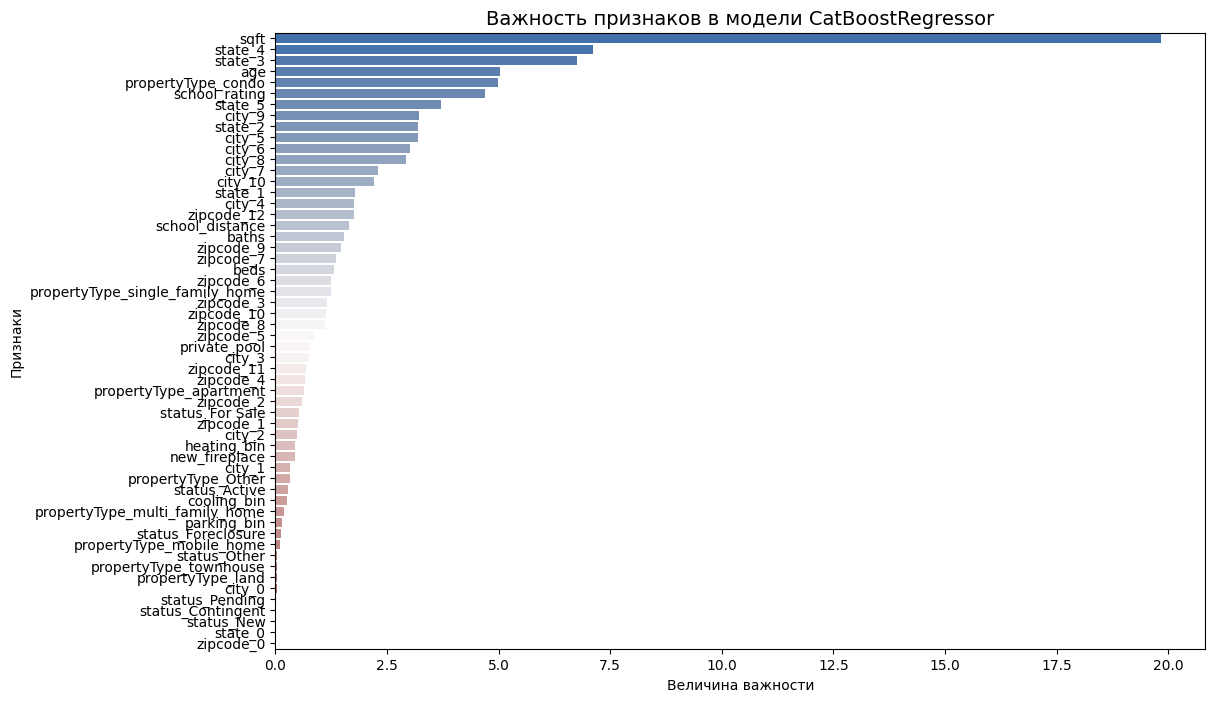

In [146]:
# Преобразуем массив важности признаков в градиентном бустинге в объект Series
cat_boost_feateres = pd.Series(cat_boost_regressor.get_feature_importance(),
                         index=X_train.columns).sort_values(ascending=False)

# Построим диаграмму, иллюстрирующую важность признаков в модели
fig = plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data = cat_boost_feateres.to_frame(name='importance').reset_index(),
    x = 'importance',
    y = 'index',
    orient = 'h',
    palette = 'vlag'
);
barplot.set_title('Важность признаков в модели CatBoostRegressor', fontsize = 14);
barplot.set_xlabel('Величина важности');
barplot.set_ylabel('Признаки');

Как мы видим, лидирует с большим отрывом в важности признаков площадь sqft, что закономерно.

In [147]:
# Создаем сводную таблицу
models = {
    'Модель': ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'GradientBoostingRegressor', 'StackingRegressor', 'CatBoostRegressor'],
    'R2': [0.44, 0.64, 0.73, 0.79, 0.79, 0.79],
    'MAPE': [75.88, 40.27, 38.02, 28.17, 27.66, 33.72],
    'MAE': [248589.98, 164606.66, 145679.81, 116759.79, 117398.44, 132381.82]
}
table = pd.DataFrame(models)

formatted_table = table.to_string(index=False, justify='center')

# Выводим сводную таблицу
print(formatted_table)

          Модель           R2   MAPE     MAE  
         LinearRegression 0.44 75.88 248589.98
    DecisionTreeRegressor 0.64 40.27 164606.66
    RandomForestRegressor 0.73 38.02 145679.81
GradientBoostingRegressor 0.79 28.17 116759.79
        StackingRegressor 0.79 27.66 117398.44
        CatBoostRegressor 0.79 33.72 132381.82


Мы можем наблюдать как с увеличением сложности модели, увеличивается и качество метрик. Наилучшие метрики на тестовом наборе данных показали модели градиентного бустинга и стекинга, эти модели показали равный коэффициент R2, но вот метрика MAE оказалась ниже у градиентного бустинга, а MAPE у стекинга. Немаловажным считаю фактор времени обучения модели, так что всё же GradientBoostingRegressor имеет преимущество. Следует отметить, что модель CatBoostRegressor не сильно уступая в метриках, не имеет признаков переобучения.

При этом полученные максимальные значения метрик нельзя назвать эталонными. Думаю основная причина в первоначальном качестве данных на входе. К большому сожалению, колоссальная работа, проделанная на этапе предобработки не смогла дать сверхрезульата. 

## Адаптация модели для внедрения в продакшн

Модель CatBoostRegressor не показала признаки переобучения и при этом не сильно уступает в метриках своим ближайшим конкурентам (GradientBoostingRegressor и StackingRegressor), поэтому считаю, что  лучшим решением будет внедрить в продакшн именно её.

Мы используем библиотеку Pickle для сохранения обученной модели CatBoostRegressor путем ее сериализации в файл. Затем на сервере можно просто загрузить этот файл и восстановить модель, готовую к выполнению прогнозов о стоимости недвижимости.

Чтобы убедиться в корректной работе развернутой модели на сервере, предоставляется пример предсказания на тестовом наборе данных.

In [149]:
import pickle

# Производим сериализацию модели и сохраняем ее в файл формата pkl
with open('best_model.pkl', 'wb') as output:
    pickle.dump(cat_boost_regressor, output)

In [151]:
# Определение тестового набора данных
test_info = [3,3000,4,1,1,8,1,0,1,0,0,1,1,1,1,1,1,0,1,0,1,1,0,1,1,0,1,0,0,1,0,1,1,1,1,1,1,0,1,0,1,1,0,1,1,0,1,0,0,1,0,1,1,1,0,0,1]
# Преобразование в массив numpy и изменение формы
test_info = np.array(test_info).reshape(1, -1) # преобразуем в датафрейм
# Предсказание с использованием обученной модели 
predictions = cat_boost_regressor.predict(test_info)
# Вывод результата предсказания для проверки
print('Предсказание:', round(predictions[0]))

Предсказание: 371974


In [153]:
# pip freeze > requirements.txt